# Modeling the Major Indices: 
- S&P 500
- Nasdaq
- Dow Jones
- Russell 2000

## Notebook Guide:
- Data Understanding
- Process Outline
- Models
    - Dow 12, 1, 3, 6 month iterations
    - S&P 1, 3, 6, 12 month iterations
    - Nasdaq 1, 3, 6, 12 month iterations
    - Russell 2000 1, 3, 6, 12 month iterations
 - Conclusion

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

<hr style="border: 4px solid red">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

from inferencial_functions import describe_predictions, plot_test_accuracy
from other_functions import compare_curves
from classification_classes import Importance
sns.set_style("dark")
pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 45)

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

In [3]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [4]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

### Importing Data

In [6]:
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(4)

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1964-02-06,^GSPC,76.930000,76.930000,77.260002,76.470001,0.0,4110000.0,669.822,3.50,0.0024,0.0006,-0.0023,0.0004,0.0006,NaN,64.329769,76.168076,76.456788,76.7455,77.034212,77.322924,0.983026,0.294062,316.1823,1,2,4,Thursday,1964-03-06,1964-05-06,1964-08-06,1965-02-08,0.017938,0.053685,0.057325,0.130248,1.0,1.0,1.0,1.0
1,1964-02-07,^GSPC,77.180000,77.180000,77.510002,76.660004,0.0,4710000.0,669.822,3.52,0.0037,-0.0006,0.0014,0.0008,0.0036,NaN,68.197375,76.234617,76.513558,76.7925,77.071442,77.350383,0.971905,0.301594,363.5178,1,2,4,Friday,1964-03-09,1964-05-07,1964-08-07,1965-02-08,0.014900,0.051438,0.060637,0.126587,1.0,1.0,1.0,1.0
2,1964-02-10,^GSPC,77.050003,77.050003,77.769997,76.830002,0.0,4150000.0,669.822,3.53,-0.0013,0.0017,-0.0020,0.0013,-0.0016,NaN,64.376738,76.331949,76.582974,76.8340,77.085026,77.336051,0.969269,0.293688,319.7575,1,2,4,Monday,1964-03-10,1964-05-11,1964-08-10,1965-02-10,0.019987,0.049968,0.061389,0.122128,1.0,1.0,1.0,1.0
3,1964-02-11,^GSPC,77.330002,77.330002,77.650002,76.809998,0.0,4040000.0,669.822,3.52,0.0033,-0.0003,-0.0014,0.0021,0.0038,NaN,68.391587,76.385595,76.634047,76.8825,77.130953,77.379405,0.958710,0.306483,312.4132,1,2,4,Tuesday,1964-03-11,1964-05-11,1964-08-11,1965-02-11,0.020949,0.046166,0.057287,0.106168,1.0,1.0,1.0,1.0


In [14]:
df[df["Ticker"] == '^RUT'].index.min()

Timestamp('1987-10-15 00:00:00')

In [9]:
# Change to Datetime

df["Date"] = pd.to_datetime(df["Date"])

In [10]:
# Move the Date to the index column

df.set_index("Date", inplace=True)

# Data Understanding
Looking at this market data from the index level reduces the overall volatility of the markets as much as possible. Each of these indexes is made up of many stocks, and therefore insulated against the outsized swings of any individual stocks within the index. The Dow is primarily legacy industrial, staple, and financial stocks, and is imbalanced relatively infrequently, the S&P 500 is composed of the 500 largest market cap US listed companies from a variety of sectors, the Nasdaq is made up primarily of tech companies, and the Russell 2000 are small cap stocks, many of whom are not yet profitable, but have tremendous potential for growth. 

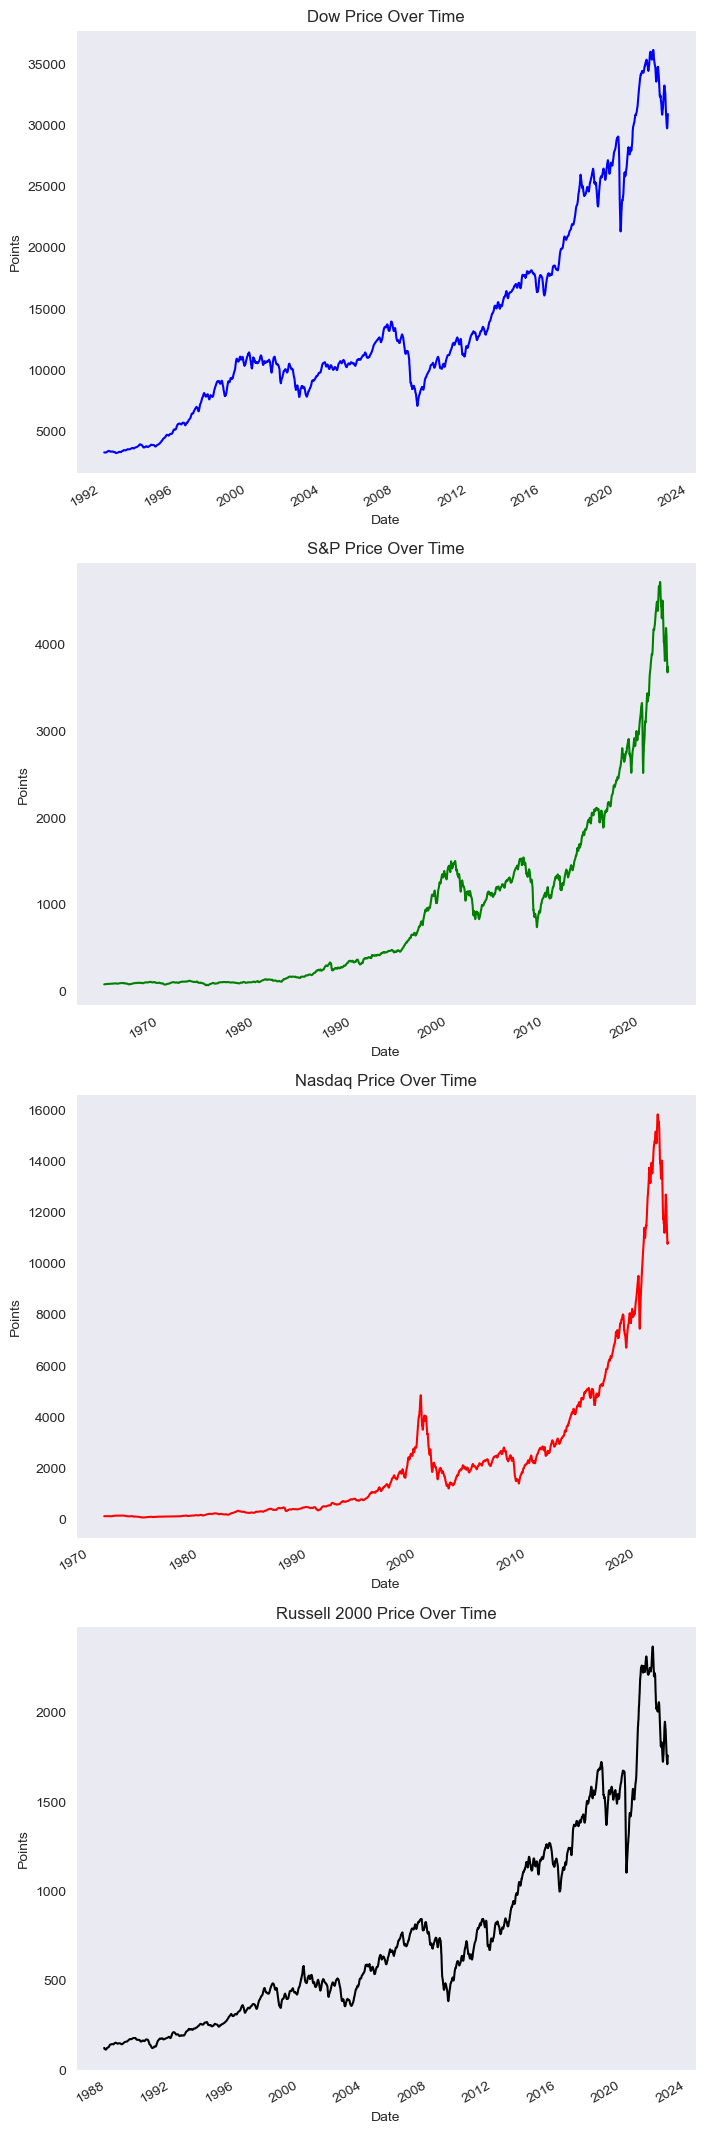

In [8]:
# Plots of the indices, smoothed using 20-day moving averages
fig, ax = plt.subplots(nrows=4, figsize=(8,30))

df[df["Ticker"] == "^DJI"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="blue", ax=ax[0])
ax[0].set_ylabel("Points")
ax[0].set_title("Dow Price Over Time")

df[df["Ticker"] == "^GSPC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="green", ax=ax[1])
ax[1].set_ylabel("Points")
ax[1].set_title("S&P Price Over Time")

df[df["Ticker"] == "^IXIC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="red", ax=ax[2])
ax[2].set_ylabel("Points")
ax[2].set_title("Nasdaq Price Over Time")

df[df["Ticker"] == "^RUT"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="black", ax=ax[3])
ax[3].set_ylabel("Points")
ax[3].set_title("Russell 2000 Price Over Time");

### Heatmap
The features exhibiting the strongest correlation with one another are all related to the specific price of the moment, and therefore, the strength of these correlations is not a surprise.

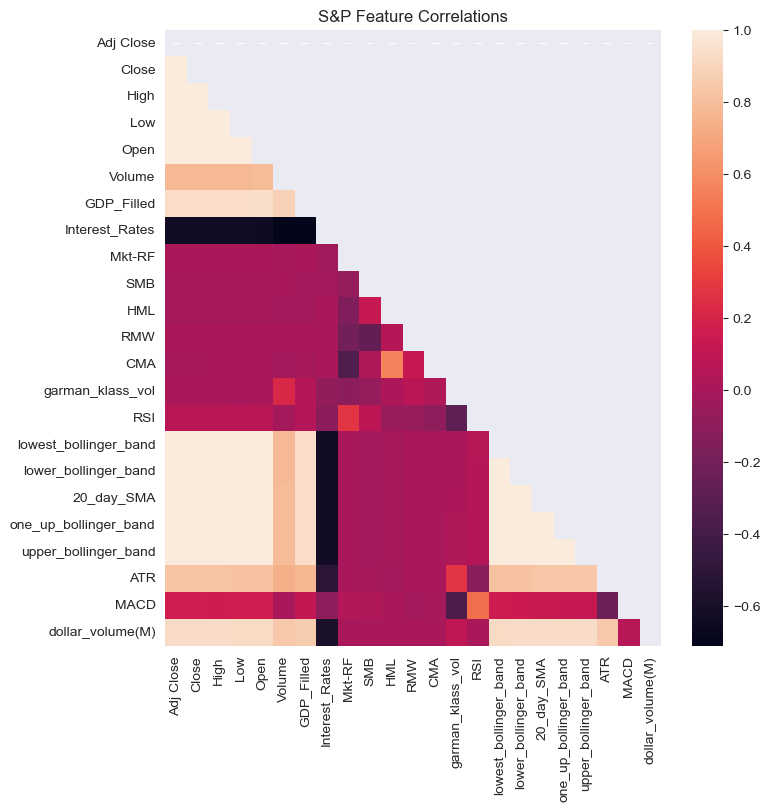

In [9]:
# Heatmap of S&P Correlations

fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("dark")

mask = np.triu(np.ones_like(df.drop(columns=["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr()))


sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
                ["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr(),\
            mask=mask, annot=True, ax=ax)

ax.set_title("S&P Feature Correlations");

### Correlations to Target

In [10]:
df.reset_index(inplace=True)

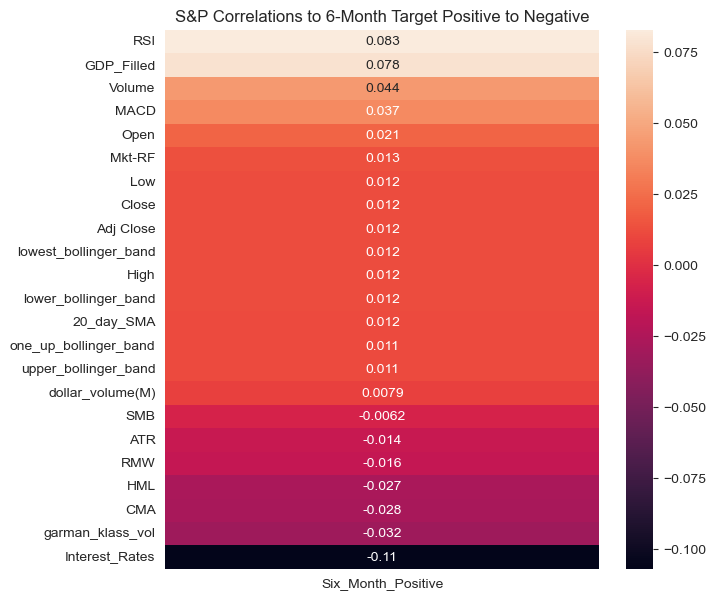

In [11]:
# S&P heatmap of correlations to target

fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("dark")

sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
        ["Date", "Ticker", "one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
         'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive', 'Quarter', 'Month',\
         'cycle_year', 'day_of_week', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
         'Twelve_Month_Change']).corr()[["Six_Month_Positive"]].sort_values(by="Six_Month_Positive", \
                                                                            ascending=False)[1:], annot=True, ax=ax)

ax.set_title("S&P Correlations to 6-Month Target Positive to Negative");

<hr style="border: 3px solid black">

# Missing Data
The missing data is exclusively Garman-Klass Vol. Other technical indicators have already been dropped which intially require a fixed window of time to generate. Also logically for recent history, it is impossible to label the outcomes of dates a year into the future that have yet to pass, so the data ends around Fall 2022. 

In [12]:
# Shows the amount of data to be dropped in order to consolidate everything into null-free data

df.shape[0], df.shape[0] - df.dropna().shape[0]

(43966, 4491)

### Setting up the df properly

In [13]:
df.set_index("Date", inplace=True)
df["day_of_week"] = df["day_of_week"].astype(str)
df["Quarter"] = df["Quarter"].astype(str)
df["Month"] = df["Month"].astype(str)
df["cycle_year"] = df['cycle_year'].astype(str)

In [14]:
# Unique DF's based on the TARGET time horizon 

one_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                'twelve_months_later', 'Three_Month_Positive', 'Six_Month_Positive', \
                                'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


three_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                  'twelve_months_later', 'One_Month_Positive', 'Six_Month_Positive', \
                                  'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


six_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
                                'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive',\
                               'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', 'Twelve_Month_Change'])


twelve_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                   'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', \
                                   'Six_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])

In [15]:
# For Verification

twelve_month_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43966 entries, 1964-02-06 to 2022-11-02
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 43966 non-null  object 
 1   Adj Close              43966 non-null  float64
 2   Close                  43966 non-null  float64
 3   High                   43966 non-null  float64
 4   Low                    43966 non-null  float64
 5   Open                   43966 non-null  float64
 6   Volume                 43966 non-null  float64
 7   GDP_Filled             43966 non-null  float64
 8   Interest_Rates         43966 non-null  float64
 9   Mkt-RF                 43966 non-null  float64
 10  SMB                    43966 non-null  float64
 11  HML                    43966 non-null  float64
 12  RMW                    43966 non-null  float64
 13  CMA                    43966 non-null  float64
 14  garman_klass_vol       39475 non-null

<hr style="border: 2px solid green">

### Re-Visiting Macro Data for Six Month Windows
To provide a bit of insight into how Macro Economic factors like GDP and federal interest rates impact stock returns, we will look at those features' characteristics when they appreciate over a 6 month period, and when they do not.

In [16]:
# Macro Statistics when indices increase in value over a 6 month period

df[df["Six_Month_Positive"] == 1][["GDP_Filled", "Interest_Rates"]].describe()

,GDP_Filled,Interest_Rates
count,30033.000000,30033.000000
mean,10966.181758,3.571803
std,6467.165622,3.041161
min,669.822000,-0.050000
25%,6004.733000,0.330000
50%,9900.169000,3.640000
75%,16319.541000,5.310000
max,26408.405000,17.140000


##### GDP
`Mean GDP is slightly higher when indices increase in value`, and the `Median GDP is surprisingly LOWER` for times when indices increase in value `over 6 months` compared to when they do not.

##### Interest Rates 
Over 6 months, mean Interest Rates are `slightly lower when indices increase in value`, and `median interest rates are also slightly lower` when indices increase in value. 

In [17]:
# Macro Statistics when indices do not increase in value over a 6 month period 

df[df["Six_Month_Positive"] == 0][["GDP_Filled", "Interest_Rates"]].describe()

,GDP_Filled,Interest_Rates
count,13933.000000,13933.000000
mean,10692.932357,4.071540
std,7092.895746,3.308188
min,697.319000,-0.010000
25%,4507.894000,1.590000
50%,10470.231000,3.850000
75%,14898.999000,5.980000
max,26408.405000,17.010000


In [18]:
six_month_df["Six_Month_Positive"].value_counts()

Six_Month_Positive
1.0    30033
0.0    13933
Name: count, dtype: int64

In [19]:
# It makes sense that Interest Rates would be negatively correlated, but it is a bit strange that GDP is also

six_month_df[["Six_Month_Positive", "GDP_Filled", "Interest_Rates"]].corr()[["GDP_Filled", "Interest_Rates"]][0:1]

,GDP_Filled,Interest_Rates
Six_Month_Positive,0.019052,-0.074124


In [20]:
# The technical indicators exhibit the strongest correlation, but nothing to an objectionable level

print("Top 5 Most Positive Correlations")
six_month_df.drop(columns=["Ticker", "day_of_week", "Quarter", "Month", 'cycle_year']).corr()\
["Six_Month_Positive"].sort_values(ascending=False)[1:6]

Top 5 Most Positive Correlations


RSI           0.044623
GDP_Filled    0.019052
MACD          0.017134
Mkt-RF        0.010494
Open         -0.006430
Name: Six_Month_Positive, dtype: float64

In [21]:
# Entries per index -> going back to 1964 for the S&P, more recent for other indices
print(df.index.min())
df["Ticker"].value_counts()

1964-02-06 00:00:00


Ticker
^GSPC    14634
^IXIC    12891
^RUT      8759
^DJI      7682
Name: count, dtype: int64

<hr style="border: 2px solid purple">

# Breaking Data into Index Groups

### Dow Jones

In [22]:
# Different groups for each respective target time horizon

dow_one_month = one_month_df[one_month_df["Ticker"] == "^DJI"]
dow_three_month = three_month_df[three_month_df["Ticker"] == "^DJI"]
dow_six_month = six_month_df[six_month_df["Ticker"] == "^DJI"]
dow_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^DJI"]

dow_one_month.shape, dow_twelve_month.shape

((7682, 29), (7682, 29))

### S&P 500

In [23]:
# Different groups for each respective target time horizon

SnP_one_month = one_month_df[one_month_df["Ticker"] == "^GSPC"]
SnP_three_month = three_month_df[three_month_df["Ticker"] == "^GSPC"]
SnP_six_month = six_month_df[six_month_df["Ticker"] == "^GSPC"]
SnP_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^GSPC"]

SnP_one_month.shape, SnP_twelve_month.shape

((14634, 29), (14634, 29))

### Nasdaq Composite

In [24]:
# Different groups for each respective target time horizon

nasdaq_one_month = one_month_df[one_month_df["Ticker"] == "^IXIC"]
nasdaq_three_month = three_month_df[three_month_df["Ticker"] == "^IXIC"]
nasdaq_six_month = six_month_df[six_month_df["Ticker"] == "^IXIC"]
nasdaq_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^IXIC"]

nasdaq_one_month.shape, nasdaq_twelve_month.shape

((12891, 29), (12891, 29))

### Russell 2000

In [25]:
# Different groups for each respective target time horizon

russell_one_month = one_month_df[one_month_df["Ticker"] == '^RUT']
russell_three_month = three_month_df[three_month_df["Ticker"] == '^RUT']
russell_six_month = six_month_df[six_month_df["Ticker"] == '^RUT']
russell_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == '^RUT']

russell_one_month.shape, russell_twelve_month.shape

((8759, 29), (8759, 29))

# Class For Data Collection, pre-model Prep

In [26]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test, threshold=.5):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.threshold = threshold
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        if self.threshold == .5:
            self.y_pred = self.model.predict(self.X_test)
        else:
            self.y_pred = (self.model.predict_proba(self.X_test)[:, 1] >= self.threshold).astype(int)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        sns.set_style("dark")
        fig, ax = plt.subplots(figsize=(6,6))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        sns.set_style("dark")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=30)
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    
    def confusion_matrix(self):
        sns.set_style('white')
        # Confusion Matrix Plot
        fig, ax = plt.subplots(figsize=(6,6))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title(f'Confusion Matrix for "{self.name}" Test Data');
    
    
    def __str__(self):
      return f"Model name: {self.name}"

# Dummy Model and Train Test Split

Now that the data has been split into 16 total segments, both by target and then subsequently by index, we can begin to establish a dummy baseline model for classification, and then build out sklearn Pipelines to hand our data pre processing and avoid any kind of data leakage. As you can see, the longer the time horizon, the more likely the most frequently occuring class would be the correct prediction. Given that, I will start with the 12 Month target groups, and go backward from there.

In [27]:
# Showing the ratios of gains to losses at different timeframes

print(one_month_df["One_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      three_month_df["Three_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), \
      six_month_df["Six_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      twelve_month_df["Twelve_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}))

One_Month_Positive
Profitable        26891
Not Profitable    17075
Name: count, dtype: int64 Three_Month_Positive
Profitable        28489
Not Profitable    15477
Name: count, dtype: int64 Six_Month_Positive
Profitable        30033
Not Profitable    13933
Name: count, dtype: int64 Twelve_Month_Positive
Profitable        32561
Not Profitable    11405
Name: count, dtype: int64


### Large Cell with commented out groups to avoid having to constantly re-enter the code

In [28]:
# Creating X and y groups

                # DOW GROUPS

# X = dow_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = dow_one_month["One_Month_Positive"]

# X = dow_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = dow_three_month["Three_Month_Positive"]

# X = dow_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = dow_six_month["Six_Month_Positive"]

X = dow_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
y = dow_twelve_month["Twelve_Month_Positive"]


                # S&P GROUPS

# X = SnP_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = SnP_one_month["One_Month_Positive"]

# X = SnP_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = SnP_three_month["Three_Month_Positive"]

# X = SnP_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = SnP_six_month["Six_Month_Positive"]

# X = SnP_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = SnP_twelve_month["Twelve_Month_Positive"]


                # NASDAQ GROUPS

# X = nasdaq_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = nasdaq_one_month["One_Month_Positive"]

# X = nasdaq_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = nasdaq_three_month["Three_Month_Positive"]

# X = nasdaq_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = nasdaq_six_month["Six_Month_Positive"]

# X = nasdaq_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = nasdaq_twelve_month["Twelve_Month_Positive"]


                # RUSSELL GROUPS

# X = russell_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = russell_one_month["One_Month_Positive"]

# X = russell_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = russell_three_month["Three_Month_Positive"]

# X = russell_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = russell_six_month["Six_Month_Positive"]

# X = russell_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = russell_twelve_month["Twelve_Month_Positive"]

In [29]:
# 3.4 to 1 ratio for Dow 12 Month Return, a little bit imbalanced but not horrendous

y.value_counts()

Twelve_Month_Positive
1.0    5992
0.0    1690
Name: count, dtype: int64

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7682 entries, 1992-02-06 to 2022-11-02
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Adj Close              7682 non-null   float64
 1   Close                  7682 non-null   float64
 2   High                   7682 non-null   float64
 3   Low                    7682 non-null   float64
 4   Open                   7682 non-null   float64
 5   Volume                 7682 non-null   float64
 6   GDP_Filled             7682 non-null   float64
 7   Interest_Rates         7682 non-null   float64
 8   Mkt-RF                 7682 non-null   float64
 9   SMB                    7682 non-null   float64
 10  HML                    7682 non-null   float64
 11  RMW                    7682 non-null   float64
 12  CMA                    7682 non-null   float64
 13  garman_klass_vol       7682 non-null   float64
 14  RSI                    7682 non-null  

<hr style="border: 4px solid royalblue">

# Train Test Split

In [31]:
# The actual data split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1313)

# Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [32]:
dummy = DummyClassifier(strategy="most_frequent")

In [33]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [34]:
dummy_model_first = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


In [35]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.778511,0.778511,1.0,0.875464,7.983281,0.784487,0.784487,1.0,0.87923,7.767867,0.5


In [36]:
"Dummy Test Score:", dummy_model_first.test_score, "*"*80, y_test.value_counts(normalize=True)

('Dummy Test Score:',
 0.784487246225924,
 '********************************************************************************',
 Twelve_Month_Positive
 1.0    0.784487
 0.0    0.215513
 Name: proportion, dtype: float64)

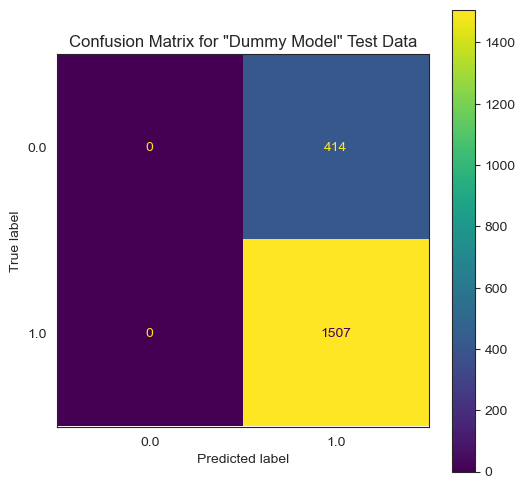

In [37]:
dummy_model_first.confusion_matrix()

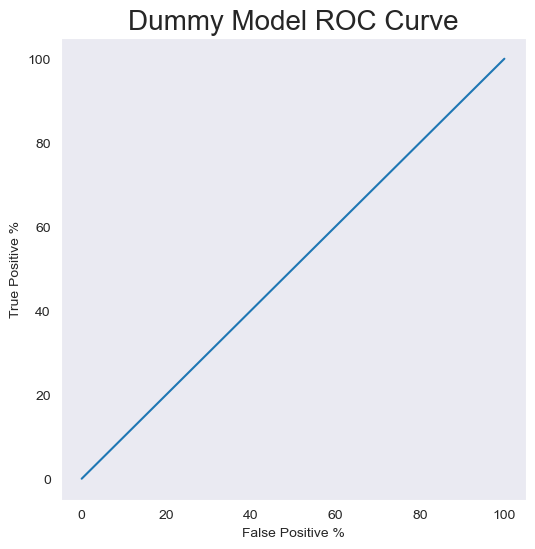

In [38]:
dummy_model_first.roc_curve()

<hr style="border: 2px solid blue;">

# Pipelines

Now that I have established a dummy baseline for our predictions, I can begin to iterate through different models using sklearn pipelines. Because my data is composed of continuous numeric values, I will only need to `SCALE` the data before processing it. I will use a variety of different models in an attempt to best predict the qualitative performance of the market on different time horizons.

In [39]:
X_train.head(2)

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter,Month,cycle_year,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-11-25,7809.000000,7809.000000,7821.390137,7739.569824,7767.200195,56360000.0,8765.907,5.16,0.0035,-0.0067,0.0014,0.0047,0.0040,0.000044,52.141419,7353.275311,7491.194418,7629.113525,7767.032632,7904.951740,137.395758,4.046021,440115.240,4,11,1,Tuesday
1997-12-09,8049.700195,8049.700195,8111.089844,8029.770020,8110.799805,51060000.0,8765.907,5.13,-0.0074,-0.0013,0.0079,0.0015,0.0039,0.000029,57.436110,7397.839935,7609.424215,7821.008496,8032.592777,8244.177058,117.292373,100.577739,411017.692,4,12,1,Tuesday


### Sub-Pipes/Column Transformer

In [40]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ('knn', KNNImputer(add_indicator=True)),
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [54]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


pipeline = Pipeline(steps=[
    ('ct', ct),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    
    )])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcf8d6fded0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcf8d6fe8f0>)])),
                ('model', KNeighborsClassifier(n_jobs=4))])

In [55]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# KNN1 = Model("K Nearest Neighbors 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
2,Random Forest 12-Month Dow,0.971880,0.978370,0.985730,0.982009,0.092518,0.977095,0.980302,0.990710,0.985479,0.074499,0.996487
3,Extra Trees 12-Month Dow,0.974657,0.982890,0.984615,0.983734,0.092329,0.977095,0.986047,0.984738,0.985392,0.065541,0.996436
5,XGBoost 12-Month Dow,0.966499,0.974632,0.982609,0.978577,0.113769,0.971369,0.975754,0.988056,0.981866,0.086271,0.994371
6,K Nearest Neighbors 12-Month Dow,0.933693,0.945223,0.971237,0.958002,0.390906,0.943259,0.957461,0.970803,0.964086,0.447149,0.965373
4,AdaBoost 12-Month Dow,0.926751,0.937576,0.970569,0.953762,0.638506,0.938574,0.943204,0.980756,0.961614,0.638158,0.977488
1,Logistic Regression 12-Month Dow,0.809582,0.838024,0.936455,0.884489,0.400412,0.813639,0.841761,0.938952,0.887704,0.388727,0.840307
0,Dummy Model,0.778511,0.778511,1.000000,0.875464,7.983281,0.784487,0.784487,1.000000,0.879230,7.767867,0.500000


### Function for conducting grid searches on tree based models

In [56]:
def best_etc_grid(estimator, model_type, sector_name, time_period):
    # Parameters to search through

    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }
    
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, verbose=1)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"GridSearched Best-Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)


In [57]:
# using the function to grid search and instantiate an object

grid_1 = best_etc_grid(estimator=rf1.model, model_type=Model, sector_name="Dow", time_period=12)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.3s finished


In [58]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
2,Random Forest 12-Month Dow,0.971880,0.978370,0.985730,0.982009,0.092518,0.977095,0.980302,0.990710,0.985479,0.074499,0.996487
3,Extra Trees 12-Month Dow,0.974657,0.982890,0.984615,0.983734,0.092329,0.977095,0.986047,0.984738,0.985392,0.065541,0.996436
7,"GridSearched Best-Model, 12-Month Dow",0.973268,0.980322,0.985507,0.982880,0.093761,0.976575,0.980921,0.989383,0.985134,0.070732,0.997046
5,XGBoost 12-Month Dow,0.966499,0.974632,0.982609,0.978577,0.113769,0.971369,0.975754,0.988056,0.981866,0.086271,0.994371
6,K Nearest Neighbors 12-Month Dow,0.933693,0.945223,0.971237,0.958002,0.390906,0.943259,0.957461,0.970803,0.964086,0.447149,0.965373
4,AdaBoost 12-Month Dow,0.926751,0.937576,0.970569,0.953762,0.638506,0.938574,0.943204,0.980756,0.961614,0.638158,0.977488
1,Logistic Regression 12-Month Dow,0.809582,0.838024,0.936455,0.884489,0.400412,0.813639,0.841761,0.938952,0.887704,0.388727,0.840307
0,Dummy Model,0.778511,0.778511,1.000000,0.875464,7.983281,0.784487,0.784487,1.000000,0.879230,7.767867,0.500000


<hr style="border: 2px solid red">

# Notes on models for 12 Month Dow
- log_reg1 2.7% increase in test accuracy, so marginal improvement. Log loss significantly better
- rf1 MASSIVE performance improvements in every statistical category.
- ET1 Extra Trees Default performed even slightly better than RandomForest! near perfect
- AdaBoost is once again significantly better than Logistic Regression and dummy, but worse than Extra/Random Tree
- XGBoost also very good, 2nd only to Extra Trees at this point
- KNN is a definite step down from the boosted/tree classifiers
- Voting Ensemble is basically inline with the other tree ensemble methods, EXTRA TREES still best
- Stacking ensemble, FWIW, has an AUC of 1, very slightly less accurate but ALSO more precise

 ### Final Note: In spite of exceptional performance, none of the models are overfit

# 12 Month Dow Stats

In [59]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
2,Random Forest 12-Month Dow,0.971880,0.978370,0.985730,0.982009,0.092518,0.977095,0.980302,0.990710,0.985479,0.074499,0.996487
3,Extra Trees 12-Month Dow,0.974657,0.982890,0.984615,0.983734,0.092329,0.977095,0.986047,0.984738,0.985392,0.065541,0.996436
7,"GridSearched Best-Model, 12-Month Dow",0.973268,0.980322,0.985507,0.982880,0.093761,0.976575,0.980921,0.989383,0.985134,0.070732,0.997046
5,XGBoost 12-Month Dow,0.966499,0.974632,0.982609,0.978577,0.113769,0.971369,0.975754,0.988056,0.981866,0.086271,0.994371
6,K Nearest Neighbors 12-Month Dow,0.933693,0.945223,0.971237,0.958002,0.390906,0.943259,0.957461,0.970803,0.964086,0.447149,0.965373
4,AdaBoost 12-Month Dow,0.926751,0.937576,0.970569,0.953762,0.638506,0.938574,0.943204,0.980756,0.961614,0.638158,0.977488
1,Logistic Regression 12-Month Dow,0.809582,0.838024,0.936455,0.884489,0.400412,0.813639,0.841761,0.938952,0.887704,0.388727,0.840307
0,Dummy Model,0.778511,0.778511,1.000000,0.875464,7.983281,0.784487,0.784487,1.000000,0.879230,7.767867,0.500000


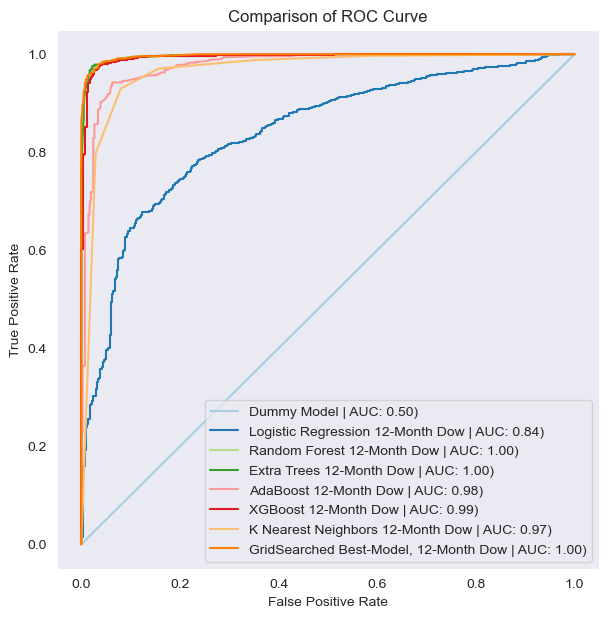

In [60]:
log_reg1.compare_roc_curve()

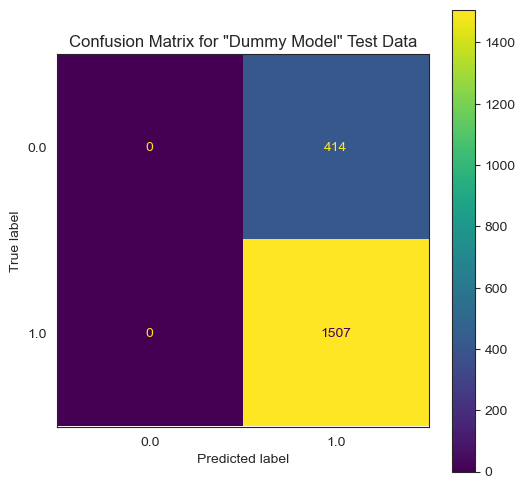

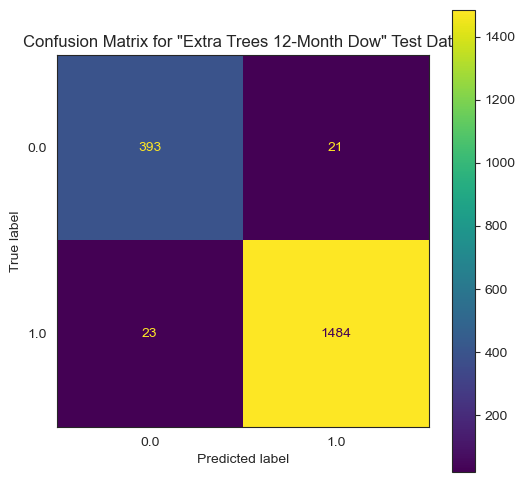

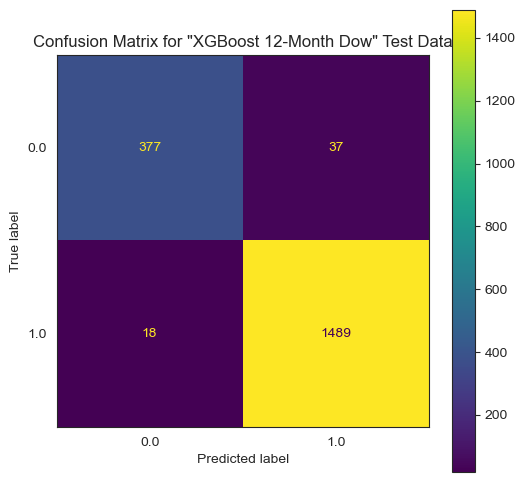

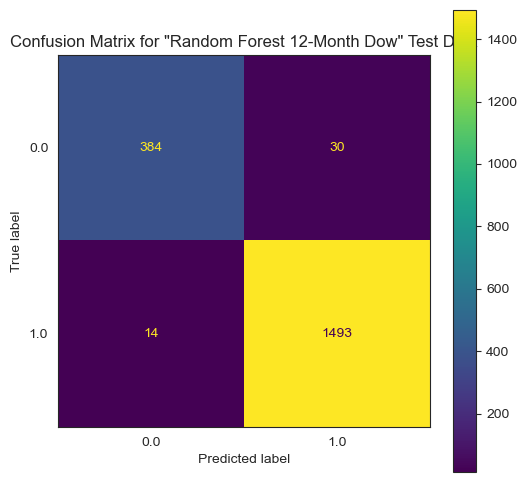

In [61]:
# Dummy CM followed by 3 best individual model CMs

for i in [dummy_model_first, ET1, XGB1, rf1]:
    i.confusion_matrix()

In [62]:
# All importances 
features_from_trees(rf1)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.12474621015322254)
('Interest_Rates', 0.11237213711611005)
('ATR', 0.0815304966293952)
('20_day_SMA', 0.05399960970043672)
('lowest_bollinger_band', 0.05284224214549763)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.042924,0.04551,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.00818,0.00973,0.01122,0.012537,0.020223,0.052842,0.044705,0.054,0.042742,0.04554,0.08153,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.0049,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657


<hr style="border: 2px solid red;">

# Functions to expedite the process

In [63]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)


def l_regr(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)



def r_forest(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

def extra_trees(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

def x_g_b(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)


def knn(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} KNN {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)


<hr style="border: 4px solid blue">

# 1 Month Dow

Now that we began with the 12 Month Dow modeling, we will iterate through every permutation of index and targets and see how well we do with our models.

# df objects to streamline modeling

In [64]:
# DFs for each ETF

# DOW
dow_df = df[df["Ticker"]== "^DJI"]

# S&P
sp_df = df[df["Ticker"]== "^GSPC"]

# Nasdac
nas_df = df[df["Ticker"]== "^IXIC"]

# Russel
rus_df = df[df["Ticker"]== "^RUT"]

In [67]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "One")

# Create Model Objects

# dummy_D_1_month = dummy_model(Model, "Dow", 1)
# logreg_D_1_month = l_regr(Model, "Dow", 1)
# knn_D_1_month = knn(Model, "Dow", 1)
# rfc_D_1_month = r_forest(Model, "Dow", 1)
# etc_D_1_month = extra_trees(Model, "Dow", 1)
# XGBoost_D_1_month = x_g_b(Model, "Dow", 1)

# grid_D_1_month = best_etc_grid(estimator=etc_D_1_month.model, model_type=Model, sector_name="Dow", time_period=1)

Model.model_df.iloc[8:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
14,"GridSearched Best-Model, 1-Month Dow",0.908349,0.917173,0.938931,0.927903,0.282523,0.912546,0.927152,0.933333,0.930233,0.251638,0.963254
12,Dow Extra Trees 1-Month,0.905917,0.919138,0.932299,0.925646,0.284050,0.909943,0.924731,0.931667,0.928186,0.266340,0.962881
11,Dow Random Forest 1-Month,0.894808,0.901853,0.934233,0.917744,0.299723,0.901614,0.910642,0.934167,0.922254,0.301463,0.961503
13,Dow XGBoost 1-Month,0.856445,0.873646,0.901904,0.887512,0.387603,0.859969,0.877534,0.901667,0.889437,0.365820,0.926021
10,Dow KNN 1-Month,0.770871,0.806612,0.835583,0.820826,1.256348,0.786569,0.813990,0.853333,0.833198,1.057534,0.849824
9,Dow Logistic Regression 1-Month,0.644499,0.661778,0.887253,0.758058,0.636074,0.648100,0.660934,0.896667,0.760962,0.630811,0.647609
8,Dummy Dow 1-Month,0.628190,0.628190,1.000000,0.771642,13.401405,0.624675,0.624675,1.000000,0.768984,13.528097,0.500000


In [68]:
# Feature importances for the best model
features_from_trees(grid_D_1_month)
Importance.df

Top 5 Feature Importances
('Adj Close', 0.045542124346116236)
('Close', 0.04498229078424514)
('one_up_bollinger_band', 0.04456681444014179)
('Low', 0.044364782024366084)
('20_day_SMA', 0.04360012688392244)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.00818,0.00973,0.01122,0.012537,0.020223,0.052842,0.044705,0.0540,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.00490,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.01534,0.01560,0.01623,0.016895,0.036911,0.041737,0.043550,0.0436,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.01082,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268


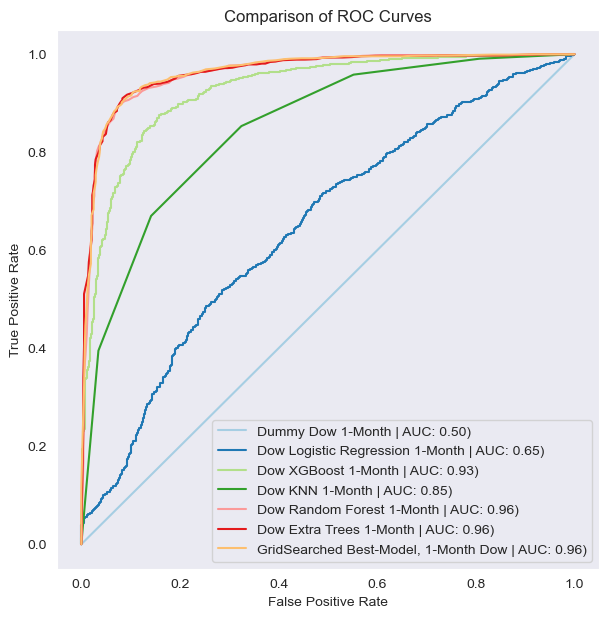

In [69]:
# Comparing model ROC curves

compare_curves([dummy_D_1_month, logreg_D_1_month, XGBoost_D_1_month, knn_D_1_month, rfc_D_1_month, etc_D_1_month, \
                grid_D_1_month])

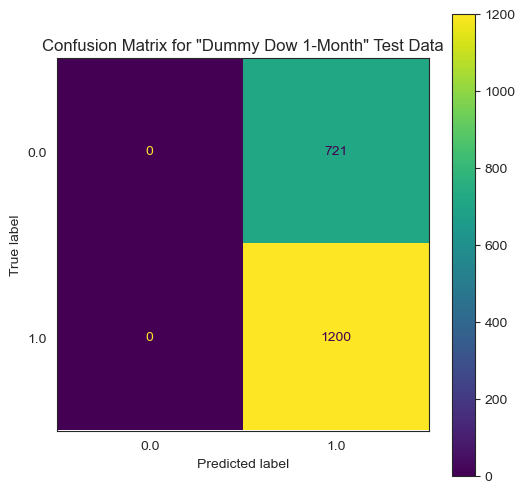

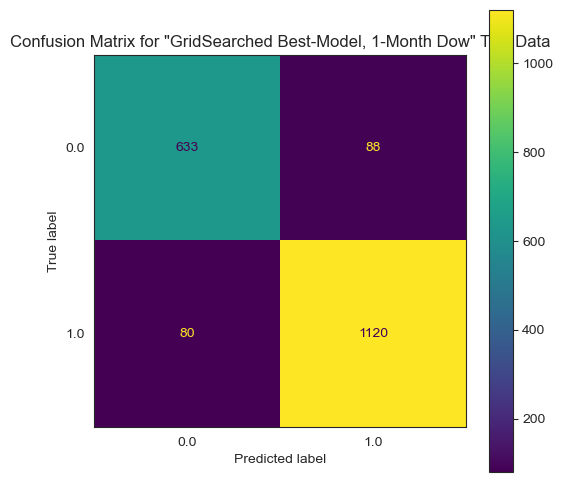

In [70]:
# Dummy CM followed by best individual model CM

for i in [dummy_D_1_month, grid_D_1_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Dow

In [73]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "Three")

# Create Model Objects

# dummy_D_3_month = dummy_model(Model, "Dow", 3)
# logreg_D_3_month = l_regr(Model, "Dow", 3)
# knn_D_3_month = knn(Model, "Dow", 3)
# rfc_D_3_month = r_forest(Model, "Dow", 3)
# etc_D_3_month = extra_trees(Model, "Dow", 3)
# XGBoost_D_3_month = x_g_b(Model, "Dow", 3)

# grid_D_3_month = best_etc_grid(estimator=etc_D_3_month.model, model_type=Model, sector_name="Dow", time_period=3)

Model.model_df.iloc[15:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
19,Dow Extra Trees 3-Month,0.939943,0.953450,0.958270,0.955839,0.186303,0.944300,0.956188,0.961360,0.958767,0.203586,0.982657
21,"GridSearched Best-Model, 3-Month Dow",0.941678,0.954236,0.960061,0.957123,0.194661,0.944300,0.955487,0.962133,0.958799,0.173380,0.983202
18,Dow Random Forest 3-Month,0.940116,0.948250,0.964414,0.956231,0.215596,0.943259,0.951945,0.964451,0.958157,0.199526,0.981272
20,Dow XGBoost 3-Month,0.923278,0.937505,0.950333,0.943846,0.226622,0.927121,0.941131,0.951314,0.946195,0.217446,0.971511
17,Dow KNN 3-Month,0.850720,0.882514,0.899639,0.890945,0.749899,0.859448,0.882661,0.912674,0.897416,0.827430,0.918080
16,Dow Logistic Regression 3-Month,0.705951,0.720570,0.924984,0.810068,0.583721,0.701718,0.717300,0.919629,0.805960,0.588474,0.674456
15,Dummy Dow 3-Month,0.678007,0.678007,1.000000,0.808110,11.605795,0.673607,0.673607,1.000000,0.804977,11.764378,0.500000


### Choosing Grid Searched model, better train, test logloss, AUC, etc

In [74]:
# Feature importances for the best model
features_from_trees(grid_D_3_month)
Importance.df

Top 5 Feature Importances
('Interest_Rates', 0.049831576746068355)
('GDP_Filled', 0.04970672742692479)
('upper_bollinger_band', 0.04396854677626732)
('lower_bollinger_band', 0.043044673446986516)
('20_day_SMA', 0.043040280601399895)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.00973,0.011220,0.012537,0.020223,0.052842,0.044705,0.05400,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.01560,0.016230,0.016895,0.036911,0.041737,0.043550,0.04360,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
2,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.01054,0.010634,0.012580,0.026614,0.042977,0.043045,0.04304,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335


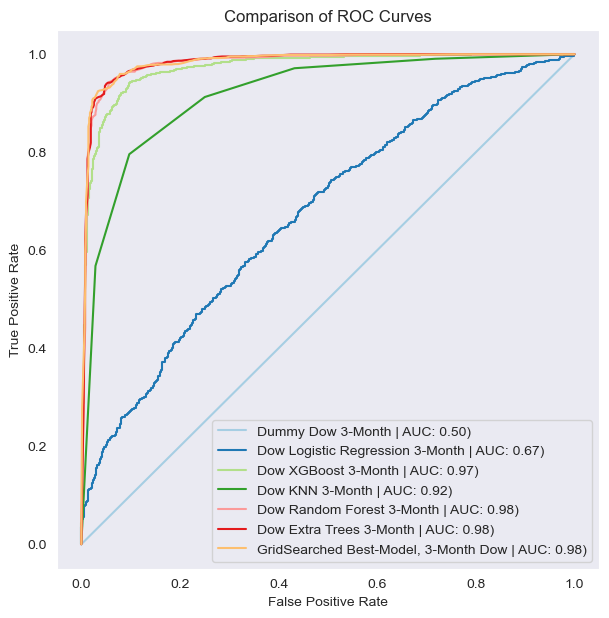

In [75]:
# Comparing model ROC curves

compare_curves([dummy_D_3_month, logreg_D_3_month, XGBoost_D_3_month, knn_D_3_month, rfc_D_3_month, etc_D_3_month, \
                grid_D_3_month])

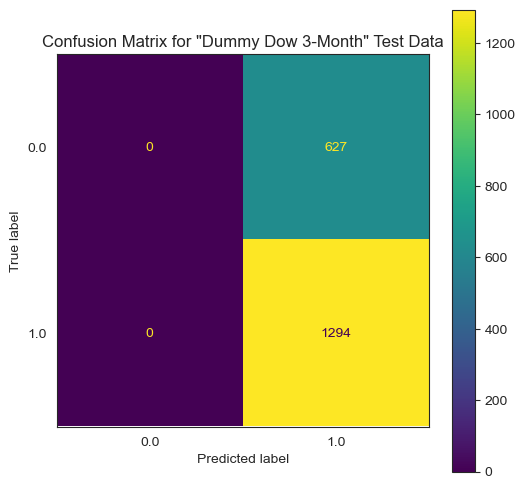

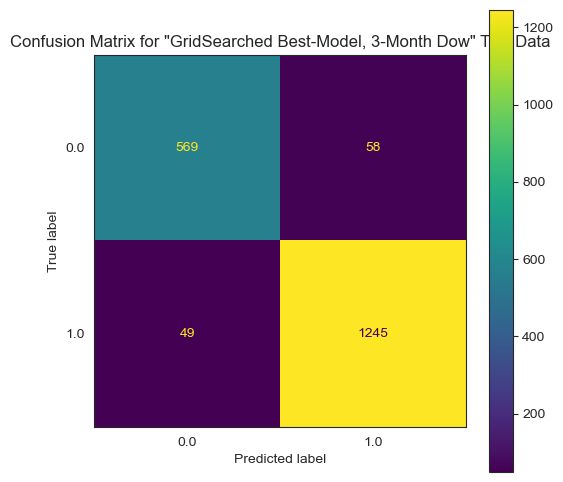

In [76]:
# Dummy CM followed by best individual model CM

for i in [dummy_D_3_month, grid_D_3_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Dow

In [79]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "Six")

# Create Model Objects

# dummy_D_6_month = dummy_model(Model, "Dow", 6)
# logreg_D_6_month = l_regr(Model, "Dow", 6)
# knn_D_6_month = knn(Model, "Dow", 6)
# rfc_D_6_month = r_forest(Model, "Dow", 6)
# etc_D_6_month = extra_trees(Model, "Dow", 6)
# XGBoost_D_6_month = x_g_b(Model, "Dow", 6)

# grid_D_6_month = best_etc_grid(estimator=etc_D_6_month.model, model_type=Model, sector_name="Dow", time_period=6)

Model.model_df.iloc[22:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
26,Dow Extra Trees 6-Month,0.959902,0.967877,0.975710,0.971771,0.133344,0.967205,0.974747,0.979695,0.977215,0.107353,0.993316
28,"GridSearched Best-Model, 6-Month Dow",0.959902,0.967877,0.975710,0.971771,0.133344,0.967205,0.974747,0.979695,0.977215,0.107353,0.993316
25,Dow Random Forest 6-Month,0.954174,0.959519,0.976446,0.967897,0.157660,0.962520,0.971841,0.976070,0.973951,0.135977,0.990685
27,Dow XGBoost 6-Month,0.946016,0.954173,0.970314,0.962170,0.163043,0.950547,0.959885,0.971719,0.965766,0.135074,0.987086
24,Dow KNN 6-Month,0.896719,0.918780,0.936945,0.927709,0.709123,0.904737,0.927143,0.941262,0.934149,0.429602,0.954368
23,Dow Logistic Regression 6-Month,0.720532,0.751281,0.904561,0.820790,0.530024,0.727225,0.764378,0.896302,0.825100,0.529193,0.732460
22,Dummy Dow 6-Month,0.707516,0.707516,1.000000,0.828708,10.542191,0.717855,0.717855,1.000000,0.835758,10.169526,0.500000


### Choosing Grid Searched model, better train, test logloss, AUC, etc

In [80]:
# Feature importances for the best model
features_from_trees(grid_D_6_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.07002368131359527)
('Interest_Rates', 0.06374966775699949)
('one_up_bollinger_band', 0.04361383612676988)
('20_day_SMA', 0.04322232353634908)
('Close', 0.04272905660078332)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
2,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
3,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349


In [82]:
# adding descriptive index name

Importance.df.rename(index={0:"12-Month Dow", 1:"1-Month Dow", 2:"3-Month Dow", 3:'6-Month Dow'}, inplace=True)

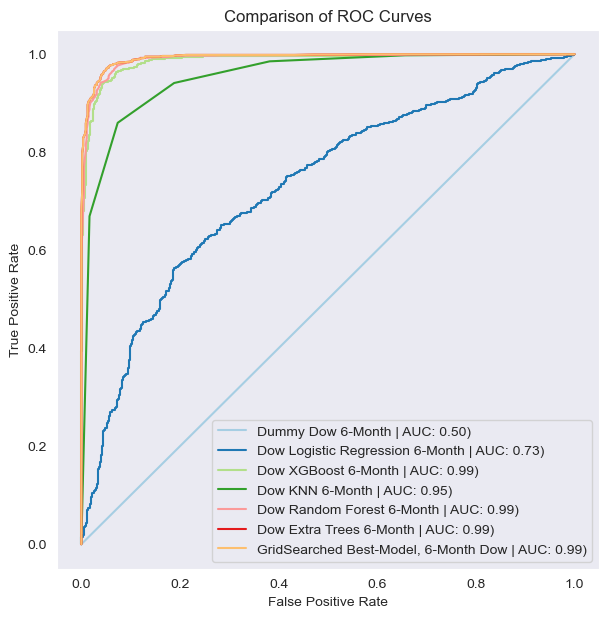

In [81]:
# Comparing model ROC curves

compare_curves([dummy_D_6_month, logreg_D_6_month, XGBoost_D_6_month, knn_D_6_month, rfc_D_6_month, etc_D_6_month, \
                grid_D_6_month])

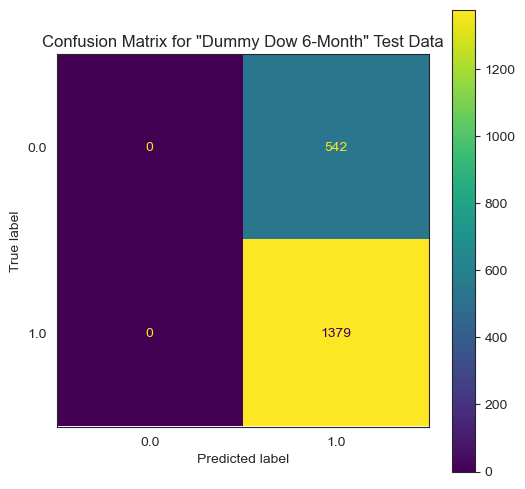

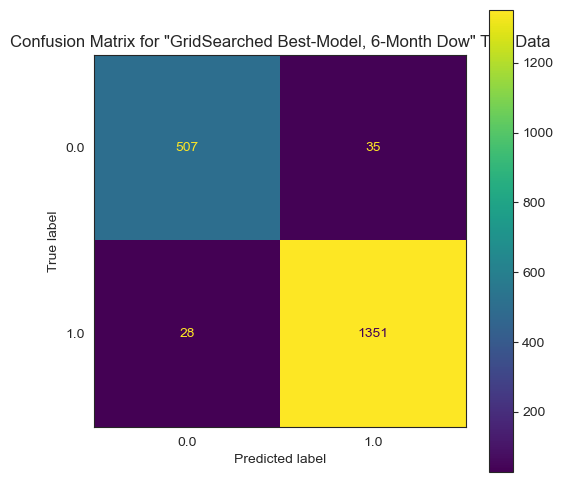

In [83]:
# Dummy CM followed by best individual model CM

for i in [dummy_D_6_month, grid_D_6_month]:
    i.confusion_matrix()

<hr style="border: 6px solid black">

# 1 Month S&P 

In [89]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "One")

# Create Model Objects

# dummy_S_1_month = dummy_model(Model, "S&P", 1)
# logreg_S_1_month = l_regr(Model, "S&P", 1)
# knn_S_1_month = knn(Model, "S&P", 1)
# rfc_S_1_month = r_forest(Model, "S&P", 1)
# etc_S_1_month = extra_trees(Model, "S&P", 1)
# XGBoost_S_1_month = x_g_b(Model, "S&P", 1)

# grid_S_1_month = best_etc_grid(estimator=etc_S_1_month.model, model_type=Model, sector_name="S&P", time_period=1)

Model.model_df.iloc[29:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
33,S&P Extra Trees 1-Month,0.905148,0.914564,0.930842,0.922614,0.269073,0.913638,0.923899,0.934714,0.929275,0.270586,0.965740
35,"GridSearched Best-Model, 1-Month S&P",0.905148,0.914564,0.930842,0.922614,0.269073,0.913638,0.923899,0.934714,0.929275,0.270586,0.965740
32,S&P Random Forest 1-Month,0.895581,0.899838,0.931892,0.915552,0.310196,0.901612,0.907578,0.932913,0.920071,0.290768,0.958874
34,S&P XGBoost 1-Month,0.837904,0.854532,0.883587,0.868799,0.403199,0.845860,0.871358,0.875281,0.873315,0.377773,0.913407
31,S&P KNN 1-Month,0.731207,0.763660,0.807379,0.784878,1.322767,0.720689,0.754998,0.799190,0.776465,1.511088,0.768362
30,S&P Logistic Regression 1-Month,0.621686,0.632693,0.899040,0.742669,0.655133,0.610823,0.625196,0.895993,0.736491,0.658208,0.587434
29,Dummy S&P 1-Month,0.607380,0.607380,1.000000,0.755739,14.151444,0.606996,0.606996,1.000000,0.755442,14.165284,0.500000


In [90]:
# Feature importances for the best model
features_from_trees(grid_S_1_month)
Importance.df

Top 5 Feature Importances
('Interest_Rates', 0.0461516406128992)
('MACD', 0.04465864258883319)
('lower_bollinger_band', 0.044412108673908775)
('20_day_SMA', 0.04420415417159832)
('one_up_bollinger_band', 0.04365763034056505)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
4,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570


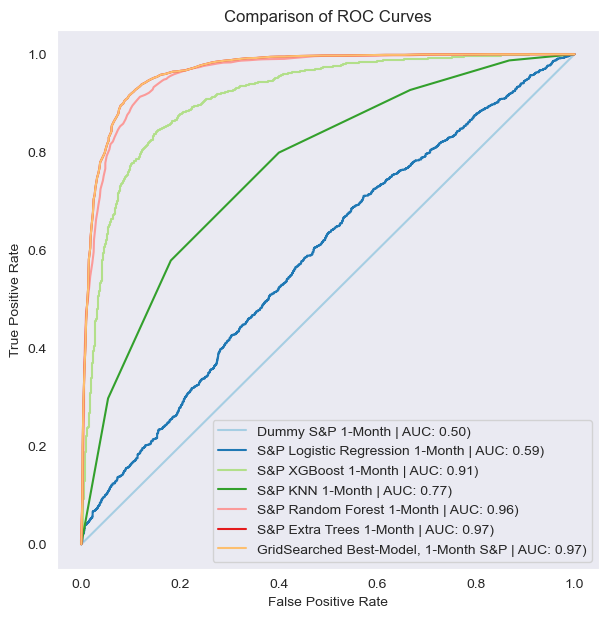

In [92]:
# Comparing model ROC curves

compare_curves([dummy_S_1_month, logreg_S_1_month, XGBoost_S_1_month, knn_S_1_month, rfc_S_1_month, etc_S_1_month, \
                grid_S_1_month])

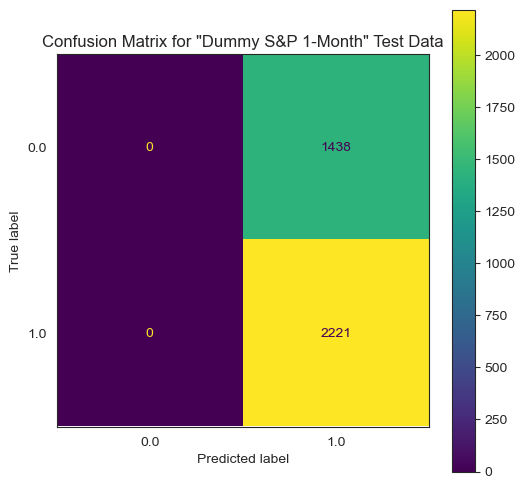

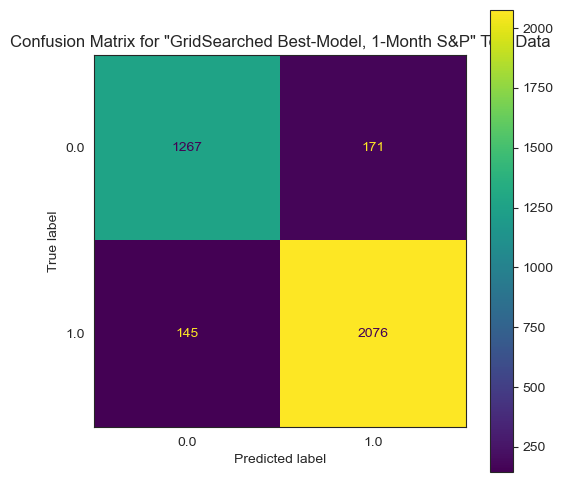

In [93]:
# Dummy CM followed by best individual model CM

for i in [dummy_S_1_month, grid_S_1_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month S&P 

In [97]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Three")

# Create Model Objects

# dummy_S_3_month = dummy_model(Model, "S&P", 3)
# logreg_S_3_month = l_regr(Model, "S&P", 3)
# knn_S_3_month = knn(Model, "S&P", 3)
# rfc_S_3_month = r_forest(Model, "S&P", 3)
# etc_S_3_month = extra_trees(Model, "S&P", 3)
# XGBoost_S_3_month = x_g_b(Model, "S&P", 3)

# grid_S_3_month = best_etc_grid(estimator=etc_S_3_month.model, model_type=Model, sector_name="S&P", time_period=3)

Model.model_df.iloc[36:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
40,S&P Extra Trees 3-Month,0.949704,0.959059,0.963593,0.961302,0.159074,0.946980,0.960358,0.957094,0.958723,0.150057,0.987200
42,"GridSearched Best-Model, 3-Month S&P",0.951253,0.958772,0.966405,0.962556,0.148317,0.946433,0.958369,0.958369,0.958369,0.157144,0.987244
39,S&P Random Forest 3-Month,0.948519,0.955016,0.966124,0.960519,0.187743,0.945340,0.957519,0.957519,0.957519,0.190529,0.983709
41,S&P XGBoost 3-Month,0.921640,0.928877,0.952066,0.940317,0.216104,0.931402,0.943858,0.949873,0.946856,0.196813,0.973940
38,S&P KNN 3-Month,0.827335,0.850332,0.890357,0.869857,0.969161,0.832468,0.856616,0.888275,0.872158,0.914342,0.894595
37,S&P Logistic Regression 3-Month,0.669431,0.684949,0.907365,0.780599,0.615634,0.665209,0.679720,0.906967,0.777070,0.618494,0.649762
36,Dummy S&P 3-Month,0.648200,0.648200,1.000000,0.786555,12.680141,0.643345,0.643345,1.000000,0.782970,12.855143,0.500000


In [98]:
# Feature importances for the best model
features_from_trees(etc_S_3_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.05424510839512973)
('Interest_Rates', 0.04930726816336291)
('one_up_bollinger_band', 0.042264799970607496)
('lower_bollinger_band', 0.042211115799269984)
('upper_bollinger_band', 0.041090881481531734)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
4,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
5,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260


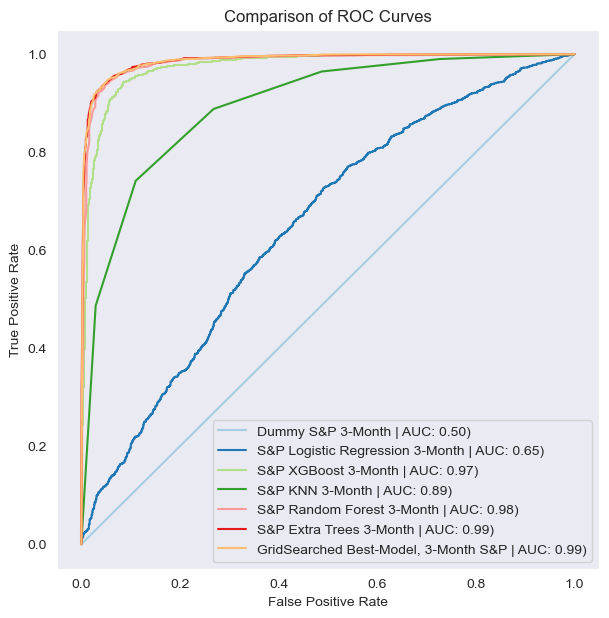

In [99]:
# Comparing model ROC curves

compare_curves([dummy_S_3_month, logreg_S_3_month, XGBoost_S_3_month, knn_S_3_month, rfc_S_3_month, etc_S_3_month, \
                grid_S_3_month])

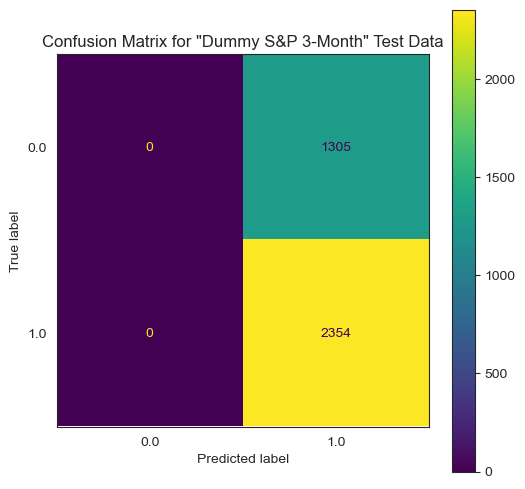

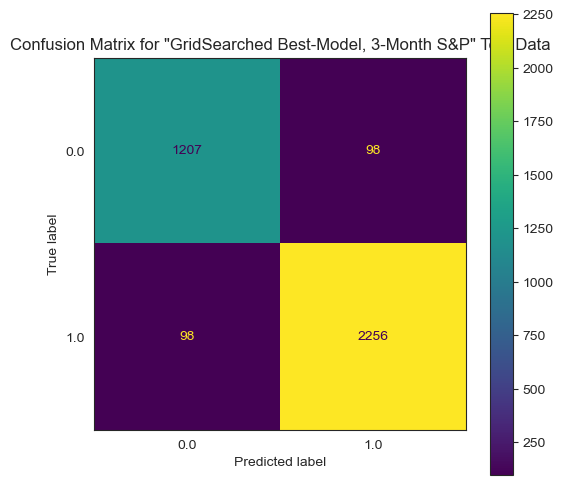

In [100]:
# Dummy CM followed by best individual model CM

for i in [dummy_S_3_month, grid_S_3_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month S&P 

In [103]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Six")

# Create Model Objects

# dummy_S_6_month = dummy_model(Model, "S&P", 6)
# logreg_S_6_month = l_regr(Model, "S&P", 6)
# knn_S_6_month = knn(Model, "S&P", 6)
# rfc_S_6_month = r_forest(Model, "S&P", 6)
# etc_S_6_month = extra_trees(Model, "S&P", 6)
# XGBoost_S_6_month = x_g_b(Model, "S&P", 6)

# grid_S_6_month = best_etc_grid(estimator=etc_S_6_month.model, model_type=Model, sector_name="S&P", time_period=6)

Model.model_df.iloc[43:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
47,S&P Extra Trees 6-Month,0.975034,0.980447,0.983044,0.981734,0.092498,0.969937,0.976229,0.979386,0.977805,0.091489,0.995081
49,"GridSearched Best-Model, 6-Month S&P",0.975581,0.980971,0.983311,0.982130,0.090760,0.968297,0.974638,0.978577,0.976603,0.097855,0.994858
46,S&P Random Forest 6-Month,0.969932,0.974324,0.981842,0.978055,0.114975,0.967751,0.970447,0.982215,0.976296,0.100098,0.994565
48,S&P XGBoost 6-Month,0.963007,0.968814,0.977303,0.973022,0.115584,0.964198,0.968413,0.978981,0.973668,0.111765,0.990790
45,S&P KNN 6-Month,0.865968,0.887641,0.920160,0.903580,0.656962,0.871823,0.896089,0.916734,0.906294,0.756614,0.926332
44,S&P Logistic Regression 6-Month,0.732210,0.742990,0.928972,0.825610,0.568438,0.733534,0.738770,0.937348,0.826296,0.567358,0.708717
43,Dummy S&P 6-Month,0.682460,0.682460,1.000000,0.811265,11.445297,0.676141,0.676141,1.000000,0.806783,11.673061,0.500000


In [104]:
# Feature importances for the best model
features_from_trees(etc_S_6_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.07340188408533306)
('Interest_Rates', 0.055617804486275686)
('cycle_year_1', 0.045493309171614406)
('20_day_SMA', 0.04363507879274619)
('lower_bollinger_band', 0.04162499292232127)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
4,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
5,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
6,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737


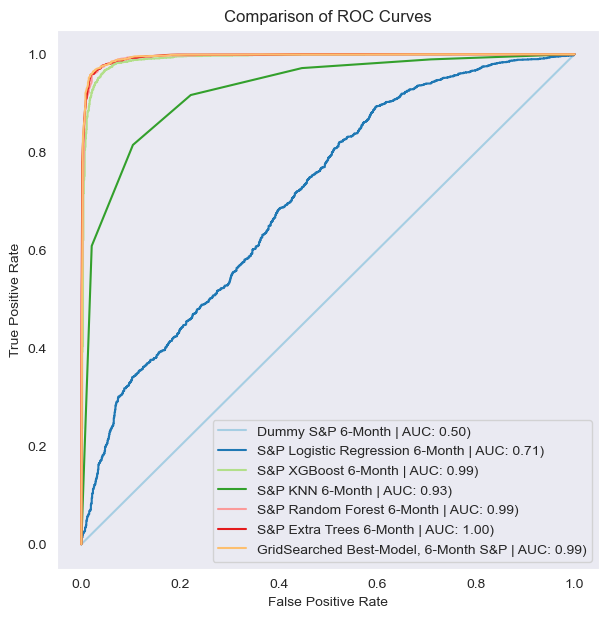

In [105]:
# Comparing model ROC curves

compare_curves([dummy_S_6_month, logreg_S_6_month, XGBoost_S_6_month, knn_S_6_month, rfc_S_6_month, etc_S_6_month, \
                grid_S_6_month])

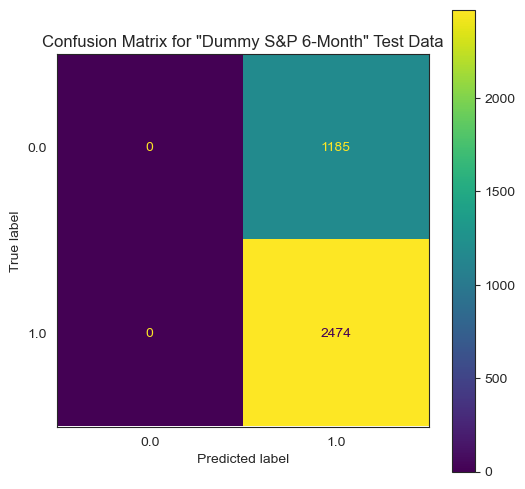

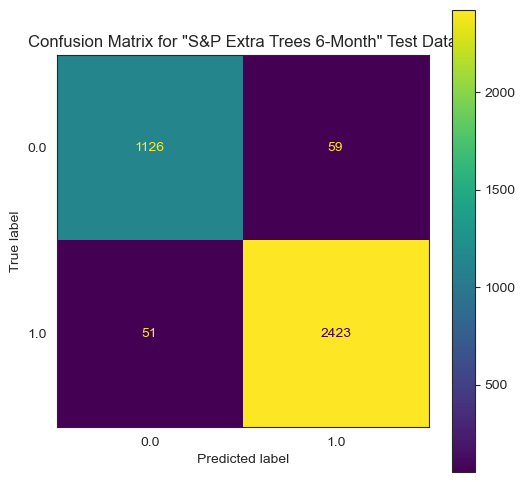

In [115]:
# Dummy CM followed by best individual model CM

for i in [dummy_S_6_month, etc_S_6_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month S&P 

In [109]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Twelve")

# Create Model Objects

# dummy_S_12_month = dummy_model(Model, "S&P", 12)
# logreg_S_12_month = l_regr(Model, "S&P", 12)
# knn_S_12_month = knn(Model, "S&P", 12)
# rfc_S_12_month = r_forest(Model, "S&P", 12)
# etc_S_12_month = extra_trees(Model, "S&P", 12)
# XGBoost_S_12_month = x_g_b(Model, "S&P", 12)

# grid_S_12_month = best_etc_grid(estimator=etc_S_12_month.model, model_type=Model, sector_name="S&P", time_period=12)

Model.model_df.iloc[50:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
54,S&P Extra Trees 12-Month,0.981412,0.985639,0.989267,0.987444,0.059547,0.983602,0.984770,0.992884,0.988810,0.047096,0.998773
53,S&P Random Forest 12-Month,0.980683,0.983951,0.990007,0.986966,0.071249,0.982782,0.981174,0.995506,0.988288,0.061101,0.998194
56,"GridSearched Best-Model, 12-Month S&P",0.982506,0.986016,0.990377,0.988187,0.067810,0.981689,0.982573,0.992509,0.987516,0.053731,0.998572
55,S&P XGBoost 12-Month,0.977312,0.981741,0.987663,0.984691,0.072525,0.979776,0.981811,0.990637,0.986204,0.065546,0.997142
52,S&P KNN 12-Month,0.897221,0.913427,0.951024,0.931828,0.552275,0.901612,0.914871,0.953933,0.933993,0.518161,0.946875
51,S&P Logistic Regression 12-Month,0.805103,0.814153,0.953863,0.878486,0.469575,0.795299,0.804052,0.951311,0.871505,0.483126,0.763970
50,Dummy S&P 12-Month,0.738588,0.738588,1.000000,0.849641,9.422254,0.729708,0.729708,1.000000,0.843735,9.742327,0.500000


In [111]:
# Feature importances for the best model
features_from_trees(etc_S_12_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08300331575658802)
('Interest_Rates', 0.05939246636700815)
('20_day_SMA', 0.04832148176574215)
('cycle_year_1', 0.04604232363838286)
('lowest_bollinger_band', 0.04535457871027239)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
4,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
5,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
6,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
7,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510


In [112]:
Importance.df.rename(index={4:"S&P 1-Month", 5:"S&P 3-Month", 6:'S&P 6-Month', 7:"S&P 12-Month"}, inplace=True)
Importance.df.tail()

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510


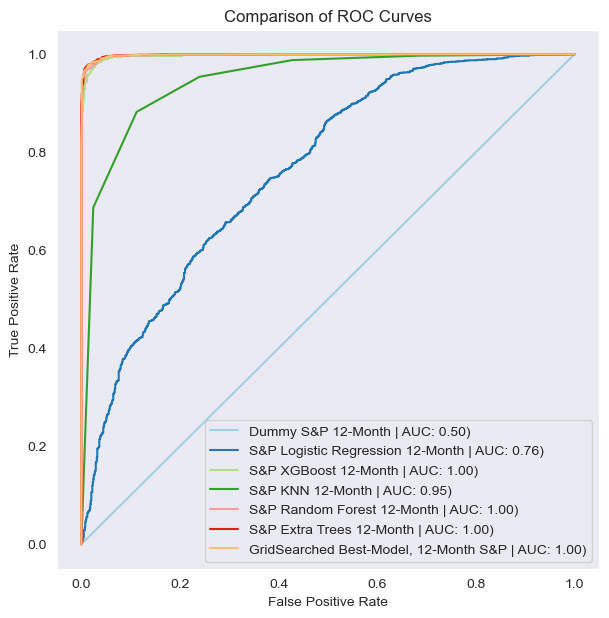

In [113]:
# Comparing model ROC curves

compare_curves([dummy_S_12_month, logreg_S_12_month, XGBoost_S_12_month, knn_S_12_month, rfc_S_12_month, etc_S_12_month, \
                grid_S_12_month])

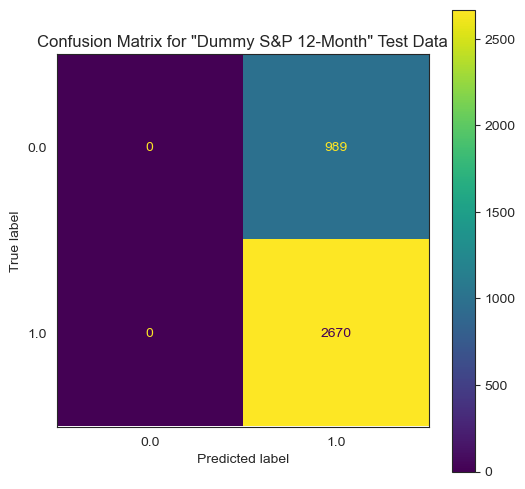

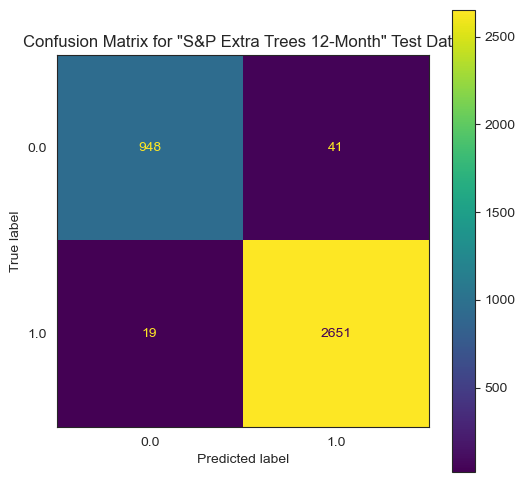

In [114]:
# Dummy CM followed by best individual model CM

for i in [dummy_S_12_month, etc_S_12_month]:
    i.confusion_matrix()

<hr style="border: 6px solid black">

# 1 Month Nasdaq 

In [118]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "One")

# Create Model Objects

# dummy_N_1_month = dummy_model(Model, "Nasdaq", 1)
# logreg_N_1_month = l_regr(Model, "Nasdaq", 1)
# knn_N_1_month = knn(Model, "Nasdaq", 1)
# rfc_N_1_month = r_forest(Model, "Nasdaq", 1)
# etc_N_1_month = extra_trees(Model, "Nasdaq", 1)
# XGBoost_N_1_month = x_g_b(Model, "Nasdaq", 1)

# grid_N_1_month = best_etc_grid(estimator=etc_N_1_month.model, model_type=Model, sector_name="Nasdaq", time_period=1)

Model.model_df.iloc[57:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
61,Nasdaq Extra Trees 1-Month,0.916012,0.926094,0.936199,0.931113,0.253106,0.922433,0.938259,0.935419,0.936837,0.218567,0.972748
63,"GridSearched Best-Model, 1-Month Nasdaq",0.918081,0.927066,0.938757,0.932861,0.246563,0.921191,0.934608,0.937437,0.936020,0.234016,0.973724
60,Nasdaq Random Forest 1-Month,0.910943,0.913311,0.942680,0.927742,0.301669,0.918399,0.926128,0.942482,0.934234,0.257735,0.971417
62,Nasdaq XGBoost 1-Month,0.855605,0.867872,0.898667,0.882982,0.365280,0.887372,0.900941,0.917760,0.909273,0.307119,0.939302
59,Nasdaq KNN 1-Month,0.730242,0.762314,0.806718,0.783823,1.342189,0.729755,0.768747,0.801715,0.784885,1.507277,0.777259
58,Nasdaq Logistic Regression 1-Month,0.627120,0.635393,0.903618,0.746105,0.655307,0.628297,0.641618,0.896065,0.747789,0.646618,0.617689
57,Dummy Nasdaq 1-Month,0.606330,0.606330,1.000000,0.754926,14.189299,0.614955,0.614955,1.000000,0.761575,13.878428,0.500000


In [120]:
# Feature importances for the best model
features_from_trees(etc_N_1_month)
Importance.df

Top 5 Feature Importances
('one_up_bollinger_band', 0.047216106139139)
('lower_bollinger_band', 0.04652106136135044)
('Interest_Rates', 0.0464455820177986)
('20_day_SMA', 0.045744616332052915)
('Adj Close', 0.045284918025605705)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510
8,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009462,0.008197,

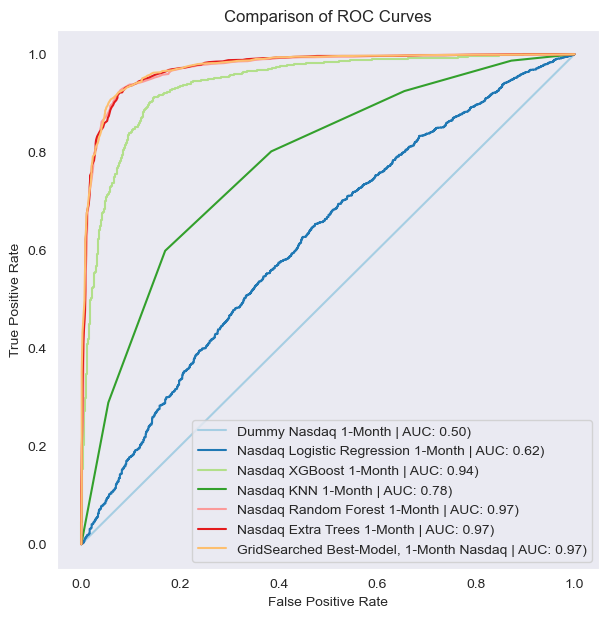

In [121]:
# Comparing model ROC curves

compare_curves([dummy_N_1_month, logreg_N_1_month, XGBoost_N_1_month, knn_N_1_month, rfc_N_1_month, etc_N_1_month, \
                grid_N_1_month])

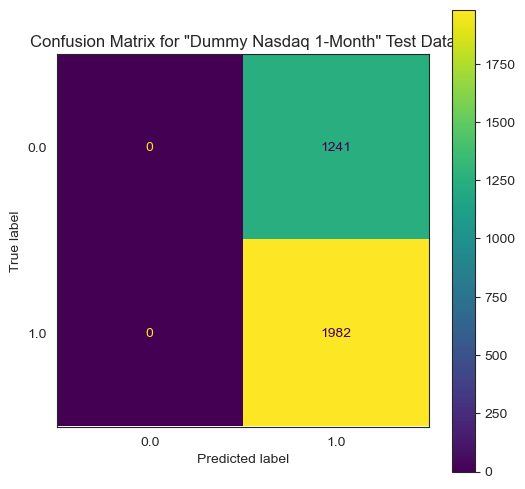

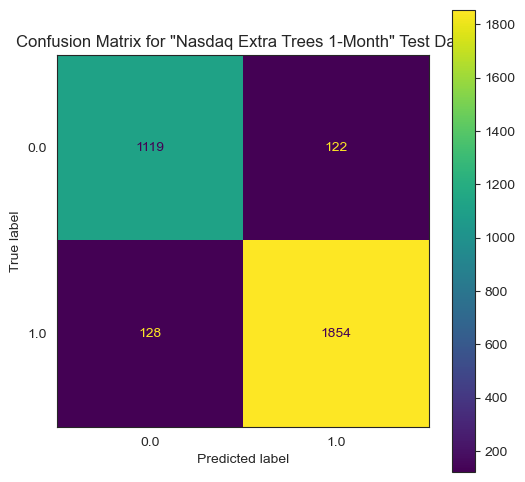

In [122]:
# Dummy CM followed by best individual model CM

for i in [dummy_N_1_month, etc_N_1_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Nasdaq

In [126]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Three")

# Create Model Objects

# dummy_N_3_month = dummy_model(Model, "Nasdaq", 3)
# logreg_N_3_month = l_regr(Model, "Nasdaq", 3)
# knn_N_3_month = knn(Model, "Nasdaq", 3)
# rfc_N_3_month = r_forest(Model, "Nasdaq", 3)
# etc_N_3_month = extra_trees(Model, "Nasdaq", 3)
# XGBoost_N_3_month = x_g_b(Model, "Nasdaq", 3)

# grid_N_3_month = best_etc_grid(estimator=rfc_N_3_month.model, model_type=Model, sector_name="Nasdaq", time_period=3)

Model.model_df.iloc[64:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
67,Nasdaq Random Forest 3-Month,0.958213,0.959704,0.975791,0.967676,0.156415,0.966491,0.969296,0.979475,0.974359,0.126787,0.993719
70,"GridSearched Best-Model, 3-Month Nasdaq",0.959247,0.959906,0.977244,0.968493,0.159316,0.965250,0.967468,0.979475,0.973435,0.128616,0.994037
68,Nasdaq Extra Trees 3-Month,0.960695,0.965733,0.973209,0.969453,0.147624,0.963388,0.974101,0.969451,0.971770,0.108444,0.993843
69,Nasdaq XGBoost 3-Month,0.933802,0.938269,0.959976,0.948958,0.183152,0.952529,0.959754,0.967542,0.963632,0.136073,0.986304
66,Nasdaq KNN 3-Month,0.822817,0.840627,0.892835,0.865930,0.940844,0.833075,0.862262,0.884487,0.873233,0.851785,0.891050
65,Nasdaq Logistic Regression 3-Month,0.666529,0.681833,0.899290,0.775582,0.619333,0.668321,0.690565,0.887351,0.776687,0.612655,0.657454
64,Dummy Nasdaq 3-Month,0.640877,0.640877,1.000000,0.781140,12.944100,0.650016,0.650016,1.000000,0.787890,12.614720,0.500000


In [127]:
# Feature importances for the best model
features_from_trees(rfc_N_3_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.0768989065863897)
('Interest_Rates', 0.06844419623300324)
('ATR', 0.054147440310502455)
('lower_bollinger_band', 0.053355366858780645)
('one_up_bollinger_band', 0.05129142779213064)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510
8,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009462,0.008197,

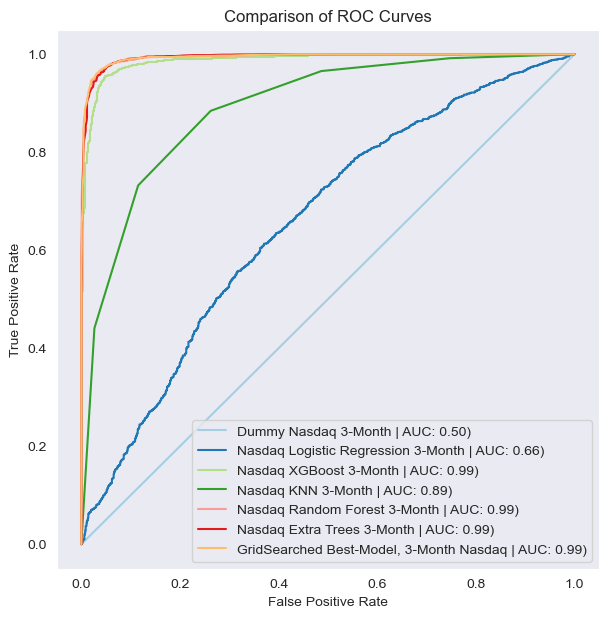

In [128]:
# Comparing model ROC curves

compare_curves([dummy_N_3_month, logreg_N_3_month, XGBoost_N_3_month, knn_N_3_month, rfc_N_3_month, etc_N_3_month, \
                grid_N_3_month])

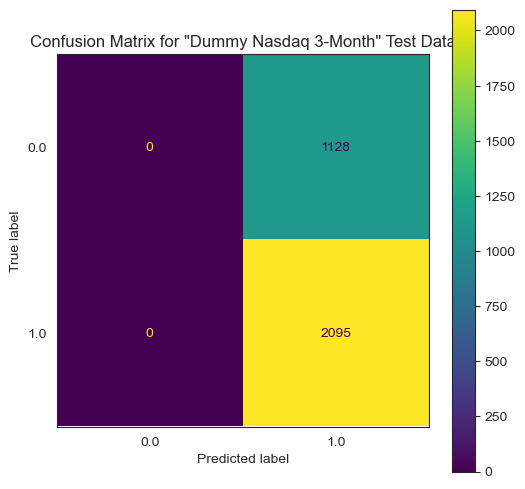

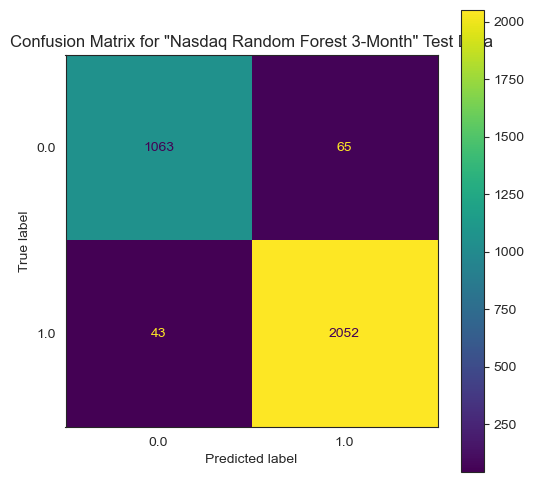

In [129]:
# Dummy CM followed by best individual model CM

for i in [dummy_N_3_month, rfc_N_3_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Nasdaq

In [133]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Six")

# Create Model Objects

# dummy_N_6_month = dummy_model(Model, "Nasdaq", 6)
# logreg_N_6_month = l_regr(Model, "Nasdaq", 6)
# knn_N_6_month = knn(Model, "Nasdaq", 6)
# rfc_N_6_month = r_forest(Model, "Nasdaq", 6)
# etc_N_6_month = extra_trees(Model, "Nasdaq", 6)
# XGBoost_N_6_month = x_g_b(Model, "Nasdaq", 6)

# grid_N_6_month = best_etc_grid(estimator=etc_N_6_month.model, model_type=Model, sector_name="Nasdaq", time_period=6)

Model.model_df.iloc[71:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
75,Nasdaq Extra Trees 6-Month,0.973935,0.978040,0.983938,0.980964,0.091508,0.979522,0.983921,0.986565,0.985242,0.064942,0.997974
77,"GridSearched Best-Model, 6-Month Nasdaq",0.974348,0.978508,0.984089,0.981266,0.099475,0.979212,0.983482,0.986565,0.985021,0.063165,0.997822
74,Nasdaq Random Forest 6-Month,0.972383,0.975258,0.984544,0.979868,0.104606,0.975799,0.978251,0.987013,0.982613,0.083284,0.997723
76,Nasdaq XGBoost 6-Month,0.966384,0.970477,0.980603,0.975504,0.105361,0.968973,0.972530,0.982983,0.977728,0.090610,0.993745
73,Nasdaq KNN 6-Month,0.864811,0.878819,0.930292,0.903787,0.722645,0.872479,0.889649,0.931482,0.910085,0.645629,0.921167
72,Nasdaq Logistic Regression 6-Month,0.709454,0.719933,0.939990,0.815350,0.578651,0.722929,0.734102,0.940887,0.824730,0.568102,0.682453
71,Dummy Nasdaq 6-Month,0.682561,0.682561,1.000000,0.811336,11.441660,0.692833,0.692833,1.000000,0.818548,11.071429,0.500000


In [135]:
# Feature importances for the best model
features_from_trees(etc_N_6_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.079116200592048)
('Interest_Rates', 0.05971245292307847)
('20_day_SMA', 0.045898045092635995)
('one_up_bollinger_band', 0.0456987760303802)
('lower_bollinger_band', 0.045620476407147864)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510
8,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009462,0.008197,

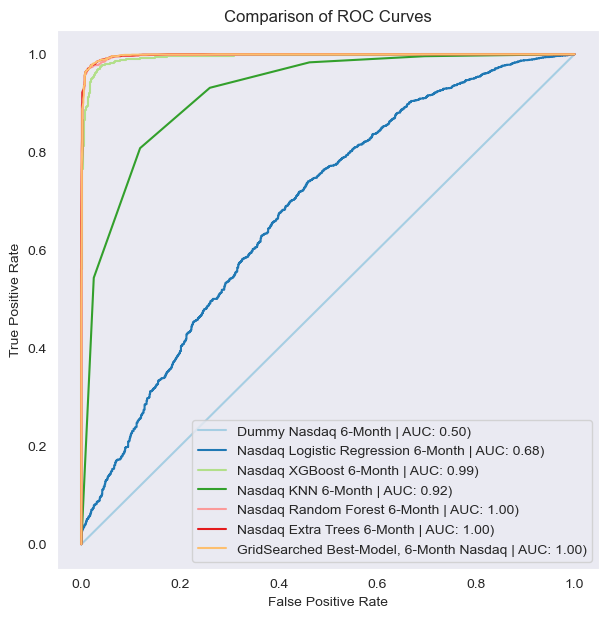

In [136]:
# Comparing model ROC curves

compare_curves([dummy_N_6_month, logreg_N_6_month, XGBoost_N_6_month, knn_N_6_month, rfc_N_6_month, etc_N_6_month, \
                grid_N_6_month])

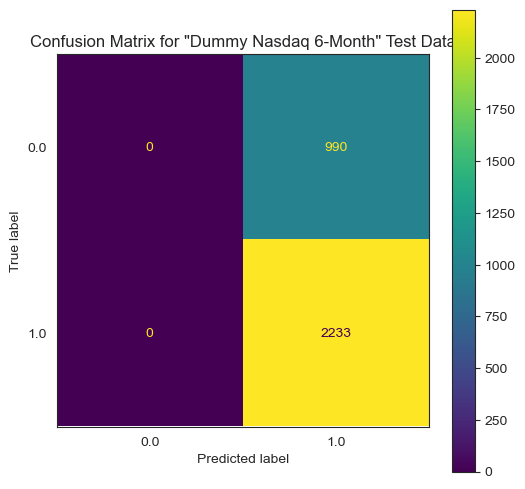

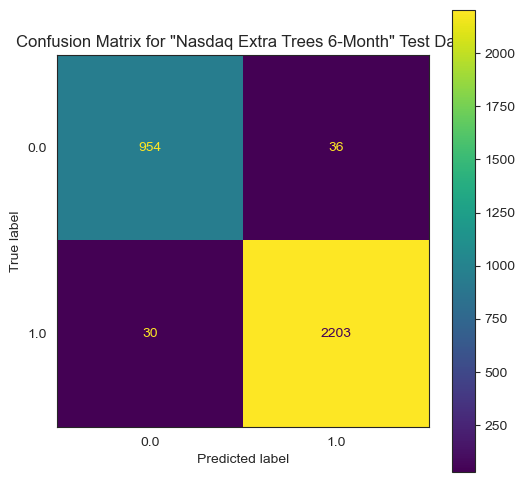

In [137]:
# Dummy CM followed by best individual model CM

for i in [dummy_N_6_month, etc_N_6_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month Nasdaq 

In [140]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Twelve")

# Create Model Objects

# dummy_N_12_month = dummy_model(Model, "Nasdaq", 12)
# logreg_N_12_month = l_regr(Model, "Nasdaq", 12)
# knn_N_12_month = knn(Model, "Nasdaq", 12)
# rfc_N_12_month = r_forest(Model, "Nasdaq", 12)
# etc_N_12_month = extra_trees(Model, "Nasdaq", 12)
# XGBoost_N_12_month = x_g_b(Model, "Nasdaq", 12)

# grid_N_12_month = best_etc_grid(estimator=rfc_N_12_month.model, model_type=Model, sector_name="Nasdaq", time_period=12)

Model.model_df.iloc[78:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
81,Nasdaq Random Forest 12-Month,0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
82,Nasdaq Extra Trees 12-Month,0.983037,0.986428,0.991047,0.988730,0.054830,0.986969,0.990095,0.992553,0.991322,0.061761,0.997269
84,"GridSearched Best-Model, 12-Month Nasdaq",0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
83,Nasdaq XGBoost 12-Month,0.978486,0.980907,0.990634,0.985746,0.066204,0.985417,0.988861,0.991725,0.990291,0.047191,0.997531
80,Nasdaq KNN 12-Month,0.886429,0.899434,0.955647,0.926677,0.637374,0.890785,0.902220,0.958213,0.929374,0.601380,0.921727
79,Nasdaq Logistic Regression 12-Month,0.802649,0.807981,0.967080,0.880385,0.477004,0.806081,0.810249,0.968142,0.882187,0.473838,0.752391
78,Dummy Nasdaq 12-Month,0.750931,0.750931,1.000000,0.857750,8.977358,0.749922,0.749922,1.000000,0.857092,9.013709,0.500000


In [142]:
# Feature importances for the best model
features_from_trees(rfc_N_12_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.14909306894419297)
('Interest_Rates', 0.09085670154227701)
('upper_bollinger_band', 0.06572911754581351)
('ATR', 0.06538914999922499)
('one_up_bollinger_band', 0.05595041559511531)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510
8,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009462,0.008197,

In [143]:
Importance.df.rename(index={8:"Nasdaq 1-Month", 9:"Nasdaq 3-Month", 10:'Nasdaq 6-Month', 11:"Nasdaq 12-Month"}, inplace=True)
Importance.df.tail(4)

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Nasdaq 1-Month,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009462,0.008197,0.008172,0.006180,0.007550,0.012073,0.010685,0.010384,0.008526,0.009755,0.010570,0.007610,0.009185,0.014452,0.013546,0.013481,0.012277,0.005511,0.005227,0.005123,0.005307,0.005083
Nasdaq 3-Month,0.043404,0.042365,0.044267,0.042983,0.041691,0.020264,0.076899,0.068444,0.008853,0.009008,0.009042,0.009313,0.009128,0.012680,0.031392,0.046173,0.053355,0.050008,0.051291,0.051096,0.054147,0.042291,...,0.011158,0.006228,0.003762,0.002326,0.002703,0.003068,0.004565,0.004987,0.004586,0.004219,0.007385,0.004101,0.003301,0.013546,0.013782,0.013524,0.012812,0.000933,0.001055,0.000823,0.000892,0.000952
Nasdaq 6-Month,0.041309,0.042595,0.043806,0.041060,0.040293,0.016831,0.079116,0.059712,0.005385,0.005760,0.005441,0.006898,0.006317,0.008199,0.021252,0.043426,0.045620,0.045898,0.045699,0.044568,0.044741,0.026123,...,0.014749,0.007073,0.005152,0.004264,0.004982,0.005393,0.006679,0.008997,0.006280,0.006742,0.007485,0.005143,0.007327,0.028937,0.030202,0.029515,0.023688,0.001954,0.002063,0.001870,0.002037,0.002020
Nasdaq 12-Month,0.040901,0.036548,0.041351,0.039834,0.041359,0.025077,0.149093,0.090857,0.003930,0.004743,0.004751,0.006009,0.005633,0.016285,0.013943,0.039706,0.046155,0.052259,0.055950,0.065729,0.065389,0.019569,...,0.007559,0.004747,0.002348,0.001160,0.002186,0.001379,0.001307,0.002150,0.000910,0.000828,0.001132,0.001200,0.001002,0.017051,0.016636,0.022503,0.007627,0.000423,0.000347,0.000407,0.000436,0.000299


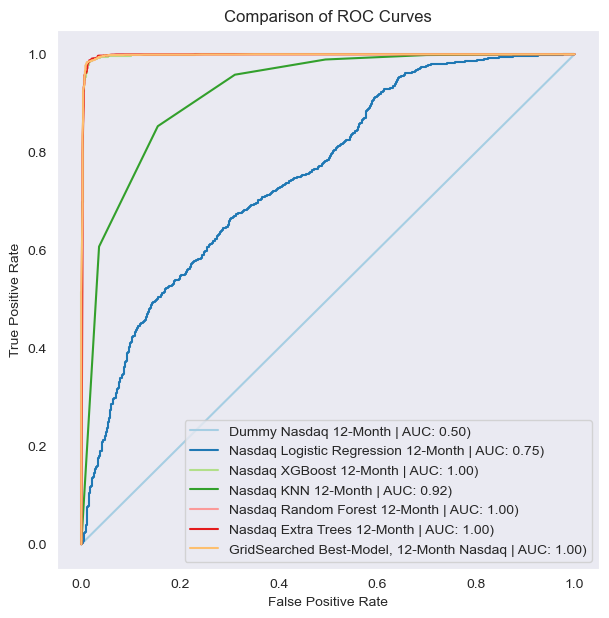

In [144]:
# Comparing model ROC curves

compare_curves([dummy_N_12_month, logreg_N_12_month, XGBoost_N_12_month, knn_N_12_month, rfc_N_12_month, etc_N_12_month, \
                grid_N_12_month])

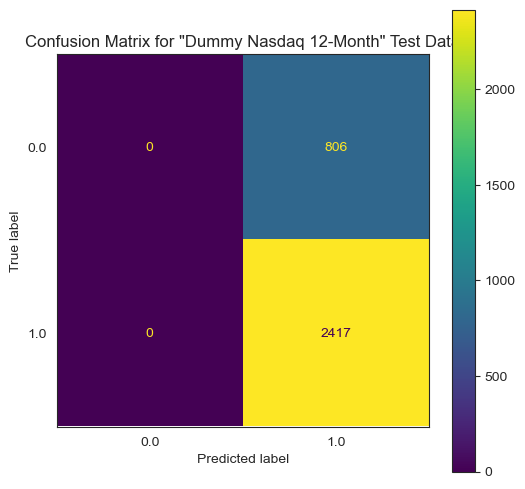

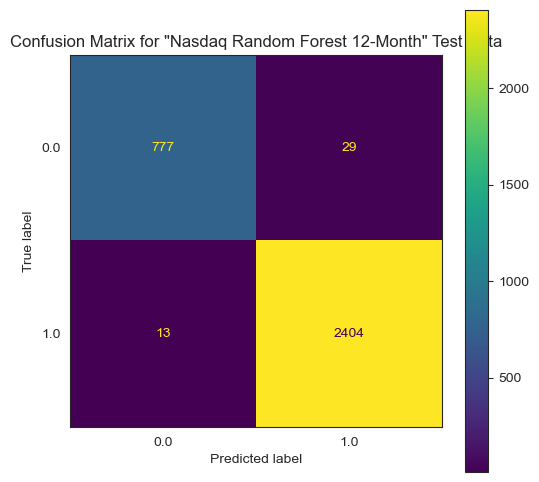

In [146]:
# Dummy CM followed by best individual model CM

for i in [dummy_N_12_month, rfc_N_12_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

<hr style="border: 6px solid black">

# 1 Month Russell 2000 

In [150]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "One")

# Create Model Objects

# dummy_R_1_month = dummy_model(Model, "Russell", 1)
# logreg_R_1_month = l_regr(Model, "Russell", 1)
# knn_R_1_month = knn(Model, "Russell", 1)
# rfc_R_1_month = r_forest(Model, "Russell", 1)
# etc_R_1_month = extra_trees(Model, "Russell", 1)
# XGBoost_R_1_month = x_g_b(Model, "Russell", 1)

# grid_R_1_month = best_etc_grid(estimator=etc_R_1_month.model, model_type=Model, sector_name="Russell", time_period=1)

Model.model_df.iloc[85:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
91,"GridSearched Best-Model, 1-Month Russell",0.901356,0.913376,0.925619,0.919415,0.275969,0.927397,0.940697,0.941395,0.941046,0.219809,0.973092
89,Russell Extra Trees 1-Month,0.899681,0.913565,0.922362,0.917901,0.272827,0.924658,0.937824,0.939911,0.938866,0.222785,0.972804
88,Russell Random Forest 1-Month,0.893592,0.898862,0.929629,0.913958,0.325215,0.913242,0.920785,0.939911,0.930250,0.274982,0.968240
90,Russell XGBoost 1-Month,0.843510,0.857738,0.890311,0.873709,0.405949,0.877169,0.887850,0.916172,0.901789,0.311399,0.940091
87,Russell KNN 1-Month,0.764503,0.788601,0.837463,0.812210,1.165977,0.778539,0.804947,0.844955,0.824466,1.229099,0.838388
86,Russell Logistic Regression 1-Month,0.631453,0.639897,0.900828,0.748204,0.652358,0.642009,0.650160,0.905786,0.756975,0.643768,0.630279
85,Dummy Russell 1-Month,0.607855,0.607855,1.000000,0.756107,14.134336,0.615525,0.615525,1.000000,0.762012,13.857880,0.500000


In [152]:
# Feature importances for the best model
features_from_trees(grid_R_1_month)
Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Nasdaq 3-Month,0.043404,0.042365,0.044267,0.042983,0.041691,0.020264,0.076899,0.068444,0.008853,0.009008,0.009042,0.009313,0.009128,0.012680,0.031392,0.046173,0.053355,0.050008,0.051291,0.051096,0.054147,0.042291,...,0.011158,0.006228,0.003762,0.002326,0.002703,0.003068,0.004565,0.004987,0.004586,0.004219,0.007385,0.004101,0.003301,0.013546,0.013782,0.013524,0.012812,0.000933,0.001055,0.000823,0.000892,0.000952
Nasdaq 6-Month,0.041309,0.042595,0.043806,0.041060,0.040293,0.016831,0.079116,0.059712,0.005385,0.005760,0.005441,0.006898,0.006317,0.008199,0.021252,0.043426,0.045620,0.045898,0.045699,0.044568,0.044741,0.026123,...,0.014749,0.007073,0.005152,0.004264,0.004982,0.005393,0.006679,0.008997,0.006280,0.006742,0.007485,0.005143,0.007327,0.028937,0.030202,0.029515,0.023688,0.001954,0.002063,0.001870,0.002037,0.002020
Nasdaq 12-Month,0.040901,0.036548,0.041351,0.039834,0.041359,0.025077,0.149093,0.090857,0.003930,0.004743,0.004751,0.006009,0.005633,0.016285,0.013943,0.039706,0.046155,0.052259,0.055950,0.065729,0.065389,0.019569,...,0.007559,0.004747,0.002348,0.001160,0.002186,0.001379,0.001307,0.002150,0.000910,0.000828,0.001132,0.001200,0.001002,0.017051,0.016636,0.022503,0.007627,0.000423,0.000347,0.000407,0.000436,0.000299
12,0.043657,0.043927,0.039967,0.042609,0.039369,0.024097,0.033303,0.043327,0.015388,0.015125,0.015105,0.014716,0.014846,0.016917,0.035839,0.043605,0.043397,0.043709,0.044600,0.043446,0.040556,0.041205,...,0.010253,0.011130,0.010181,0.007560,0.009044,0.010272,0.011690,0.009017,0.009374,0.007135,0.009269,0.006614,0.008122,0.012167,0.013290,0.013083,0.014657,0.006788,0.006973,0.006877,0.006857,0.007021


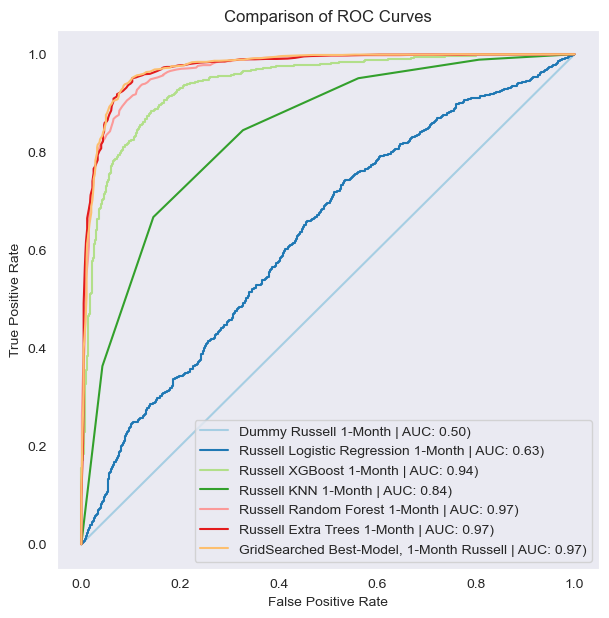

In [153]:
# Comparing model ROC curves

compare_curves([dummy_R_1_month, logreg_R_1_month, XGBoost_R_1_month, knn_R_1_month, rfc_R_1_month, etc_R_1_month, \
                grid_R_1_month])

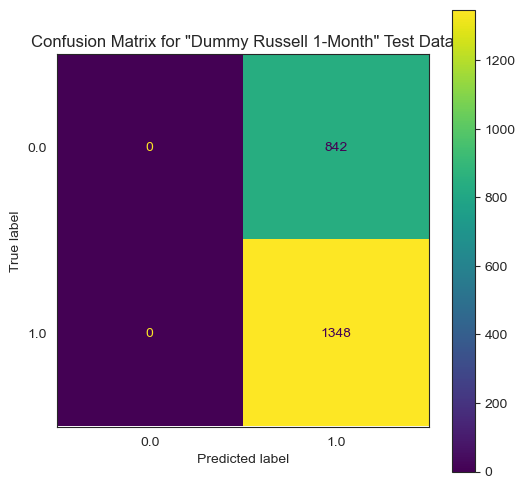

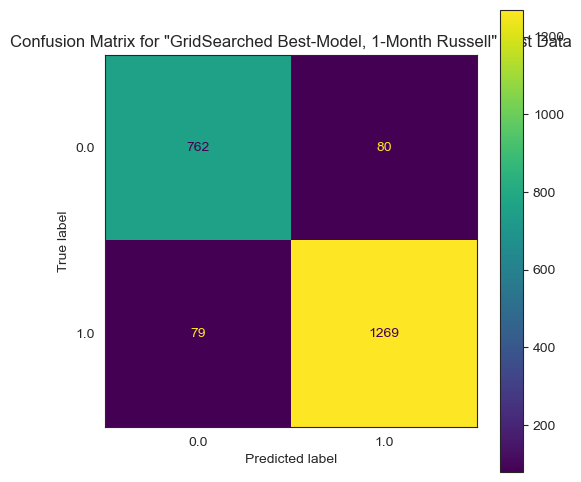

In [154]:
# Dummy CM followed by best individual model CM

for i in [dummy_R_1_month, grid_R_1_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Nasdaq

In [157]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Three")

# Create Model Objects

# dummy_R_3_month = dummy_model(Model, "Russell", 3)
# logreg_R_3_month = l_regr(Model, "Russell", 3)
# knn_R_3_month = knn(Model, "Russell", 3)
# rfc_R_3_month = r_forest(Model, "Russell", 3)
# etc_R_3_month = extra_trees(Model, "Russell", 3)
# XGBoost_R_3_month = x_g_b(Model, "Russell", 3)

# grid_R_3_month = best_etc_grid(estimator=etc_R_3_month.model, model_type=Model, sector_name="Russell", time_period=3)

Model.model_df.iloc[92:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
96,Russell Extra Trees 3-Month,0.945196,0.955493,0.957748,0.956594,0.159347,0.955251,0.963362,0.966138,0.964748,0.139951,0.988169
98,"GridSearched Best-Model, 3-Month Russell",0.946567,0.956673,0.958714,0.957676,0.151134,0.953881,0.962617,0.964697,0.963656,0.171133,0.986337
95,Russell Random Forest 3-Month,0.944436,0.951772,0.960643,0.956139,0.191552,0.947489,0.956927,0.960375,0.958648,0.173929,0.984474
97,Russell XGBoost 3-Month,0.925558,0.937482,0.944949,0.941160,0.220275,0.931507,0.942143,0.950288,0.946198,0.199821,0.974872
94,Russell KNN 3-Month,0.857208,0.874202,0.903666,0.888636,0.768815,0.874429,0.885655,0.920749,0.902861,0.723656,0.928199
93,Russell Logistic Regression 3-Month,0.691127,0.704626,0.878314,0.781922,0.606018,0.684018,0.701856,0.871758,0.777635,0.607033,0.688437
92,Dummy Russell 3-Month,0.630537,0.630537,1.000000,0.773410,13.316782,0.633790,0.633790,1.000000,0.775852,13.199548,0.500000


In [159]:
# Feature importances for the best model
features_from_trees(etc_R_3_month)
Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Nasdaq 6-Month,0.041309,0.042595,0.043806,0.041060,0.040293,0.016831,0.079116,0.059712,0.005385,0.005760,0.005441,0.006898,0.006317,0.008199,0.021252,0.043426,0.045620,0.045898,0.045699,0.044568,0.044741,0.026123,...,0.014749,0.007073,0.005152,0.004264,0.004982,0.005393,0.006679,0.008997,0.006280,0.006742,0.007485,0.005143,0.007327,0.028937,0.030202,0.029515,0.023688,0.001954,0.002063,0.001870,0.002037,0.002020
Nasdaq 12-Month,0.040901,0.036548,0.041351,0.039834,0.041359,0.025077,0.149093,0.090857,0.003930,0.004743,0.004751,0.006009,0.005633,0.016285,0.013943,0.039706,0.046155,0.052259,0.055950,0.065729,0.065389,0.019569,...,0.007559,0.004747,0.002348,0.001160,0.002186,0.001379,0.001307,0.002150,0.000910,0.000828,0.001132,0.001200,0.001002,0.017051,0.016636,0.022503,0.007627,0.000423,0.000347,0.000407,0.000436,0.000299
12,0.043657,0.043927,0.039967,0.042609,0.039369,0.024097,0.033303,0.043327,0.015388,0.015125,0.015105,0.014716,0.014846,0.016917,0.035839,0.043605,0.043397,0.043709,0.044600,0.043446,0.040556,0.041205,...,0.010253,0.011130,0.010181,0.007560,0.009044,0.010272,0.011690,0.009017,0.009374,0.007135,0.009269,0.006614,0.008122,0.012167,0.013290,0.013083,0.014657,0.006788,0.006973,0.006877,0.006857,0.007021
13,0.041496,0.040631,0.040808,0.040437,0.040237,0.019286,0.051099,0.053723,0.008358,0.008873,0.008540,0.008726,0.008536,0.010565,0.024908,0.044829,0.041336,0.041480,0.043741,0.040930,0.036404,0.030051,...,0.019751,0.013455,0.006450,0.005095,0.007283,0.008027,0.012491,0.010503,0.008066,0.007430,0.010934,0.006845,0.008661,0.022257,0.022676,0.029013,0.021982,0.003838,0.003261,0.004311,0.003677,0.002891


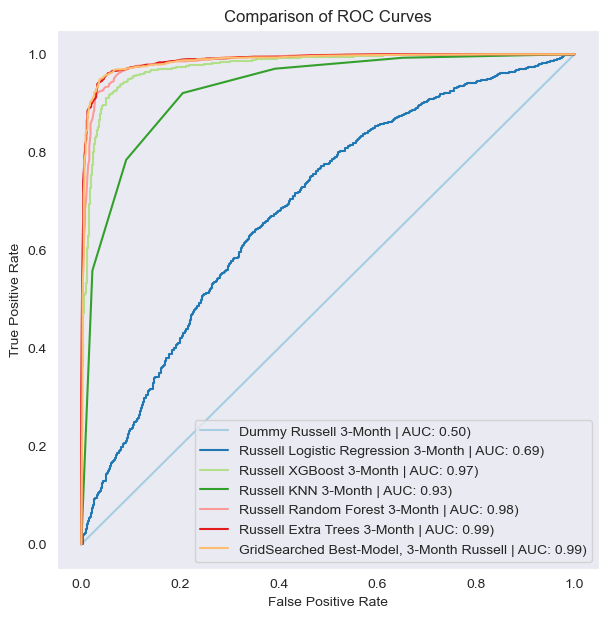

In [160]:
# Comparing model ROC curves

compare_curves([dummy_R_3_month, logreg_R_3_month, XGBoost_R_3_month, knn_R_3_month, rfc_R_3_month, etc_R_3_month, \
                grid_R_3_month])

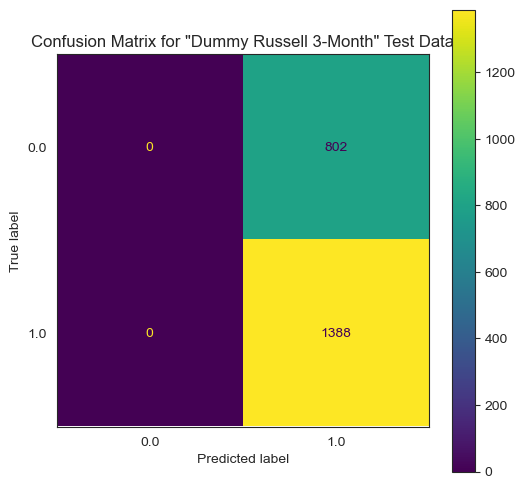

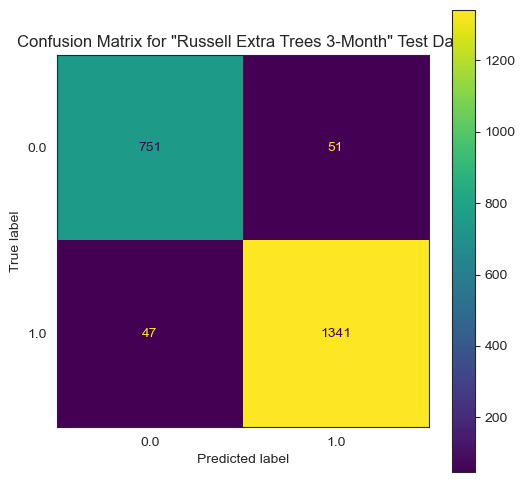

In [161]:
# Dummy CM followed by best individual model CM

for i in [dummy_R_3_month, etc_R_3_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 6 Month Russell

In [165]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Six")

# Create Model Objects

# dummy_R_6_month = dummy_model(Model, "Russell", 6)
# logreg_R_6_month = l_regr(Model, "Russell", 6)
# knn_R_6_month = knn(Model, "Russell", 6)
# rfc_R_6_month = r_forest(Model, "Russell", 6)
# etc_R_6_month = extra_trees(Model, "Russell", 6)
# XGBoost_R_6_month = x_g_b(Model, "Russell", 6)

# grid_R_6_month = best_etc_grid(estimator=etc_R_6_month.model, model_type=Model, sector_name="Russell", time_period=6)

Model.model_df.iloc[99:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
105,"GridSearched Best-Model, 6-Month Russell",0.962095,0.973057,0.969677,0.971335,0.129780,0.970320,0.974930,0.979706,0.977312,0.123772,0.993767
103,Russell Extra Trees 6-Month,0.961029,0.972802,0.968298,0.970516,0.111850,0.968037,0.974180,0.976907,0.975542,0.097272,0.994406
102,Russell Random Forest 6-Month,0.956766,0.965476,0.969446,0.967430,0.146426,0.961644,0.968641,0.972708,0.970670,0.123345,0.993413
104,Russell XGBoost 6-Month,0.948394,0.958250,0.964164,0.961182,0.150371,0.951598,0.957785,0.968509,0.963118,0.140220,0.987115
101,Russell KNN 6-Month,0.897548,0.912758,0.934754,0.923602,0.564232,0.907306,0.909759,0.952414,0.930598,0.512081,0.958475
100,Russell Logistic Regression 6-Month,0.743034,0.754778,0.906962,0.823885,0.548175,0.728311,0.740207,0.899230,0.812006,0.564197,0.746245
99,Dummy Russell 6-Month,0.662658,0.662658,1.000000,0.797107,12.159041,0.652511,0.652511,1.000000,0.789721,12.524758,0.500000


In [ ]:
dfhdjalsdfhjaslfhdjsfhajsfhjasfhjas

In [166]:
# Feature importances for the best model
features_from_trees(grid_R_6_month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.057278305701291374)
('Interest_Rates', 0.051797028021358715)
('cycle_year_3', 0.048597478718728666)
('Close', 0.042561978877974534)
('Low', 0.04186311633557835)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Nasdaq 12-Month,0.040901,0.036548,0.041351,0.039834,0.041359,0.025077,0.149093,0.090857,0.003930,0.004743,0.004751,0.006009,0.005633,0.016285,0.013943,0.039706,0.046155,0.052259,0.055950,0.065729,0.065389,0.019569,...,0.007559,0.004747,0.002348,0.001160,0.002186,0.001379,0.001307,0.002150,0.000910,0.000828,0.001132,0.001200,0.001002,0.017051,0.016636,0.022503,0.007627,0.000423,0.000347,0.000407,0.000436,0.000299
12,0.043657,0.043927,0.039967,0.042609,0.039369,0.024097,0.033303,0.043327,0.015388,0.015125,0.015105,0.014716,0.014846,0.016917,0.035839,0.043605,0.043397,0.043709,0.044600,0.043446,0.040556,0.041205,...,0.010253,0.011130,0.010181,0.007560,0.009044,0.010272,0.011690,0.009017,0.009374,0.007135,0.009269,0.006614,0.008122,0.012167,0.013290,0.013083,0.014657,0.006788,0.006973,0.006877,0.006857,0.007021
13,0.041496,0.040631,0.040808,0.040437,0.040237,0.019286,0.051099,0.053723,0.008358,0.008873,0.008540,0.008726,0.008536,0.010565,0.024908,0.044829,0.041336,0.041480,0.043741,0.040930,0.036404,0.030051,...,0.019751,0.013455,0.006450,0.005095,0.007283,0.008027,0.012491,0.010503,0.008066,0.007430,0.010934,0.006845,0.008661,0.022257,0.022676,0.029013,0.021982,0.003838,0.003261,0.004311,0.003677,0.002891
14,0.040985,0.042562,0.040439,0.041863,0.037773,0.016746,0.057278,0.051797,0.007014,0.006592,0.006466,0.007155,0.006661,0.008765,0.023618,0.037388,0.037804,0.040679,0.041409,0.038730,0.032299,0.024734,...,0.023511,0.011085,0.007146,0.005993,0.009344,0.009854,0.009379,0.011375,0.006252,0.008077,0.006608,0.005196,0.006175,0.034478,0.031948,0.048597,0.031111,0.002648,0.003308,0.003174,0.003135,0.003486


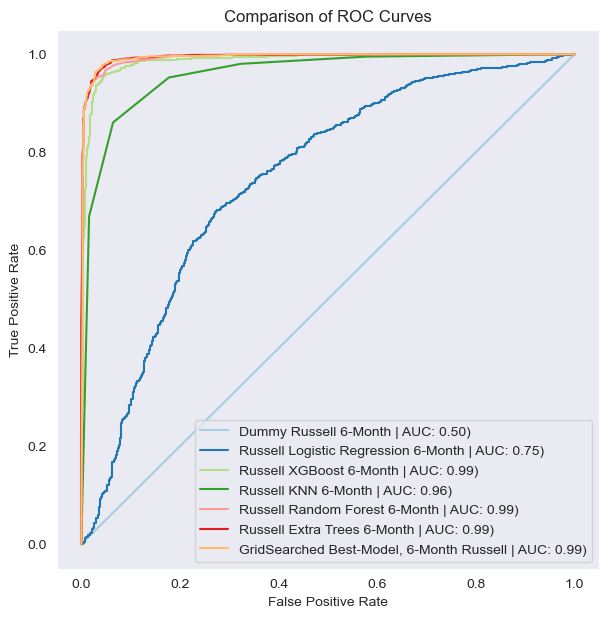

In [167]:
# Comparing model ROC curves

compare_curves([dummy_R_6_month, logreg_R_6_month, XGBoost_R_6_month, knn_R_6_month, rfc_R_6_month, etc_R_6_month, \
                grid_R_6_month])

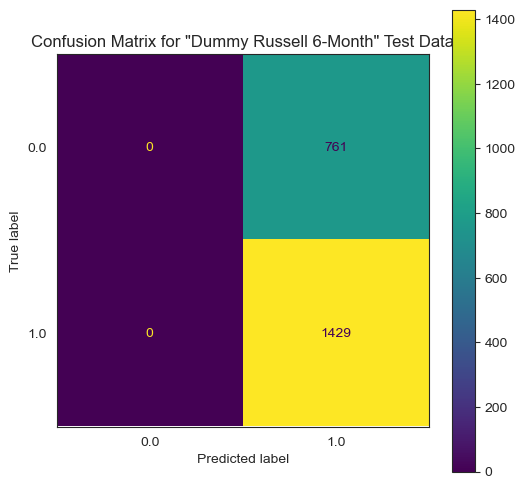

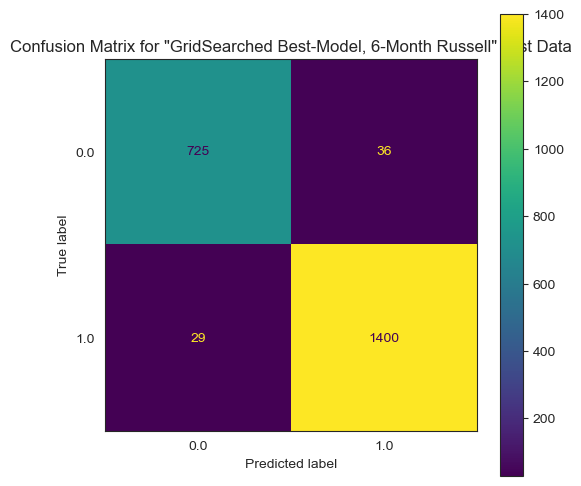

In [168]:
# Dummy CM followed by best individual model CM

for i in [dummy_R_6_month, grid_R_6_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 12 Month Nasdaq 

In [171]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Twelve")

# Create Model Objects

# dummy_R_12_month = dummy_model(Model, "Russell", 12)
# logreg_R_12_month = l_regr(Model, "Russell", 12)
# knn_R_12_month = knn(Model, "Russell", 12)
# rfc_R_12_month = r_forest(Model, "Russell", 12)
# etc_R_12_month = extra_trees(Model, "Russell", 12)
# XGBoost_R_12_month = x_g_b(Model, "Russell", 12)

# grid_R_12_month = best_etc_grid(estimator=etc_R_12_month.model, model_type=Model, sector_name="Russell", time_period=12)

Model.model_df.iloc[106:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
110,Russell Extra Trees 12-Month,0.979601,0.984566,0.986268,0.985411,0.080492,0.981279,0.986266,0.986911,0.986588,0.061570,0.997858
112,"GridSearched Best-Model, 12-Month Russell",0.979601,0.984566,0.986268,0.985411,0.080492,0.981279,0.986266,0.986911,0.986588,0.061570,0.997858
109,Russell Random Forest 12-Month,0.973664,0.978571,0.983871,0.981202,0.086244,0.975342,0.981070,0.983639,0.982353,0.083241,0.996418
111,Russell XGBoost 12-Month,0.969706,0.973887,0.983000,0.978412,0.089928,0.969863,0.975293,0.981675,0.978474,0.096740,0.994842
108,Russell KNN 12-Month,0.933018,0.939616,0.966217,0.952722,0.411829,0.928767,0.934177,0.965969,0.949807,0.444927,0.969289
107,Russell Logistic Regression 12-Month,0.775461,0.782047,0.940716,0.854064,0.485324,0.764384,0.772336,0.939136,0.847608,0.491542,0.781300
106,Dummy Russell 12-Month,0.698432,0.698432,1.000000,0.822443,10.869612,0.697717,0.697717,1.000000,0.821947,10.895387,0.500000


In [ ]:
afalsfjasl;fjdsaklfjsa;lfjaslfkfa

In [173]:
# Feature importances for the best model
features_from_trees(etc_R_12_month)
Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12,0.043657,0.043927,0.039967,0.042609,0.039369,0.024097,0.033303,0.043327,0.015388,0.015125,0.015105,0.014716,0.014846,0.016917,0.035839,0.043605,0.043397,0.043709,0.044600,0.043446,0.040556,0.041205,...,0.010253,0.011130,0.010181,0.007560,0.009044,0.010272,0.011690,0.009017,0.009374,0.007135,0.009269,0.006614,0.008122,0.012167,0.013290,0.013083,0.014657,0.006788,0.006973,0.006877,0.006857,0.007021
13,0.041496,0.040631,0.040808,0.040437,0.040237,0.019286,0.051099,0.053723,0.008358,0.008873,0.008540,0.008726,0.008536,0.010565,0.024908,0.044829,0.041336,0.041480,0.043741,0.040930,0.036404,0.030051,...,0.019751,0.013455,0.006450,0.005095,0.007283,0.008027,0.012491,0.010503,0.008066,0.007430,0.010934,0.006845,0.008661,0.022257,0.022676,0.029013,0.021982,0.003838,0.003261,0.004311,0.003677,0.002891
14,0.040985,0.042562,0.040439,0.041863,0.037773,0.016746,0.057278,0.051797,0.007014,0.006592,0.006466,0.007155,0.006661,0.008765,0.023618,0.037388,0.037804,0.040679,0.041409,0.038730,0.032299,0.024734,...,0.023511,0.011085,0.007146,0.005993,0.009344,0.009854,0.009379,0.011375,0.006252,0.008077,0.006608,0.005196,0.006175,0.034478,0.031948,0.048597,0.031111,0.002648,0.003308,0.003174,0.003135,0.003486
15,0.041186,0.040204,0.050609,0.041973,0.043271,0.015249,0.069277,0.065699,0.004282,0.003686,0.004788,0.004707,0.004785,0.005260,0.012187,0.040948,0.045885,0.048689,0.047973,0.040879,0.028635,0.013235,...,0.025687,0.005731,0.006807,0.003995,0.008909,0.005330,0.006639,0.004606,0.003922,0.002968,0.005267,0.004060,0.004743,0.043211,0.029494,0.062950,0.037139,0.001802,0.001869,0.001630,0.001459,0.001460


In [174]:
Importance.df.rename(index={12:"Russell 2000 1-Month", 13:"Russell 2000 3-Month", 14:'Russell 2000 6-Month',\
                            15:"Russell 2000 12-Month"}, inplace=True)
Importance.df.tail(4)

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Russell 2000 1-Month,0.043657,0.043927,0.039967,0.042609,0.039369,0.024097,0.033303,0.043327,0.015388,0.015125,0.015105,0.014716,0.014846,0.016917,0.035839,0.043605,0.043397,0.043709,0.044600,0.043446,0.040556,0.041205,...,0.010253,0.011130,0.010181,0.007560,0.009044,0.010272,0.011690,0.009017,0.009374,0.007135,0.009269,0.006614,0.008122,0.012167,0.013290,0.013083,0.014657,0.006788,0.006973,0.006877,0.006857,0.007021
Russell 2000 3-Month,0.041496,0.040631,0.040808,0.040437,0.040237,0.019286,0.051099,0.053723,0.008358,0.008873,0.008540,0.008726,0.008536,0.010565,0.024908,0.044829,0.041336,0.041480,0.043741,0.040930,0.036404,0.030051,...,0.019751,0.013455,0.006450,0.005095,0.007283,0.008027,0.012491,0.010503,0.008066,0.007430,0.010934,0.006845,0.008661,0.022257,0.022676,0.029013,0.021982,0.003838,0.003261,0.004311,0.003677,0.002891
Russell 2000 6-Month,0.040985,0.042562,0.040439,0.041863,0.037773,0.016746,0.057278,0.051797,0.007014,0.006592,0.006466,0.007155,0.006661,0.008765,0.023618,0.037388,0.037804,0.040679,0.041409,0.038730,0.032299,0.024734,...,0.023511,0.011085,0.007146,0.005993,0.009344,0.009854,0.009379,0.011375,0.006252,0.008077,0.006608,0.005196,0.006175,0.034478,0.031948,0.048597,0.031111,0.002648,0.003308,0.003174,0.003135,0.003486
Russell 2000 12-Month,0.041186,0.040204,0.050609,0.041973,0.043271,0.015249,0.069277,0.065699,0.004282,0.003686,0.004788,0.004707,0.004785,0.005260,0.012187,0.040948,0.045885,0.048689,0.047973,0.040879,0.028635,0.013235,...,0.025687,0.005731,0.006807,0.003995,0.008909,0.005330,0.006639,0.004606,0.003922,0.002968,0.005267,0.004060,0.004743,0.043211,0.029494,0.062950,0.037139,0.001802,0.001869,0.001630,0.001459,0.001460


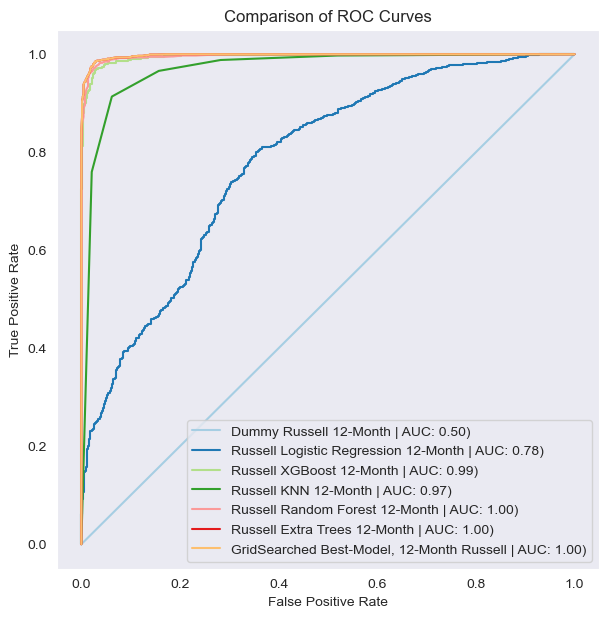

In [175]:
# Comparing model ROC curves

compare_curves([dummy_R_12_month, logreg_R_12_month, XGBoost_R_12_month, knn_R_12_month, rfc_R_12_month, etc_R_12_month, \
                grid_R_12_month])

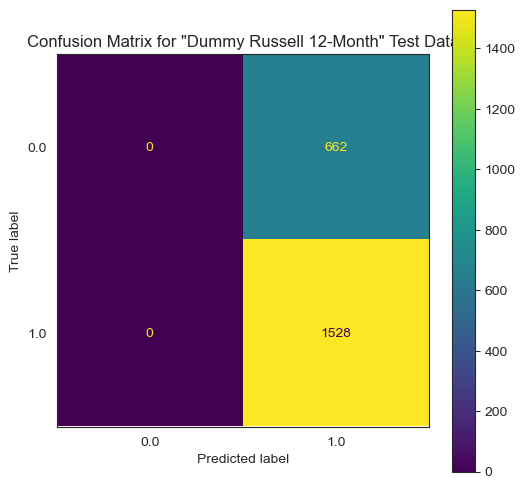

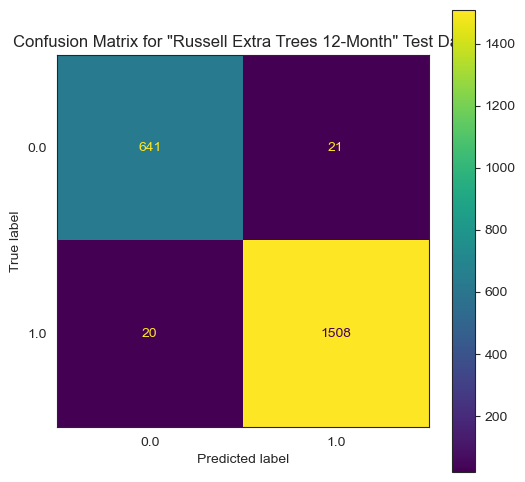

In [176]:
# Dummy CM followed by best individual model CM

for i in [dummy_R_12_month, etc_R_12_month]:
    i.confusion_matrix()

<hr style="border: 8px solid red;">

# Summary of Statistics

In [180]:
# Importances
Importance.df

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,...,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12-Month Dow,0.042924,0.045510,0.043958,0.038064,0.038568,0.024236,0.124746,0.112372,0.007291,0.006855,0.008180,0.009730,0.011220,0.012537,0.020223,0.052842,0.044705,0.054000,0.042742,0.045540,0.081530,0.018918,...,0.004483,0.002712,0.002007,0.000584,0.001415,0.000922,0.001931,0.002368,0.002177,0.000805,0.003433,0.001308,0.004036,0.004900,0.008934,0.023062,0.009373,0.000845,0.000835,0.000577,0.000715,0.000657
1-Month Dow,0.045542,0.044982,0.041996,0.044365,0.040961,0.021504,0.034618,0.042972,0.016104,0.014985,0.015340,0.015600,0.016230,0.016895,0.036911,0.041737,0.043550,0.043600,0.044567,0.041164,0.038068,0.042957,...,0.009588,0.011678,0.007211,0.006104,0.006136,0.008858,0.011358,0.009169,0.008465,0.007731,0.010106,0.008146,0.009715,0.010820,0.014531,0.015104,0.010959,0.007263,0.007064,0.006981,0.006910,0.006268
3-Month Dow,0.042575,0.042492,0.042475,0.039861,0.038568,0.018143,0.049707,0.049832,0.010045,0.009989,0.009949,0.010540,0.010634,0.012580,0.026614,0.042977,0.043045,0.043040,0.042825,0.043969,0.035653,0.031349,...,0.015531,0.013611,0.007857,0.007317,0.011201,0.007782,0.010028,0.011182,0.007709,0.008495,0.015427,0.007313,0.011177,0.017429,0.022729,0.023279,0.017689,0.004925,0.004740,0.004328,0.005344,0.004335
6-Month Dow,0.040987,0.042729,0.042421,0.041112,0.039899,0.020289,0.070024,0.063750,0.007389,0.007418,0.007765,0.007962,0.008646,0.009908,0.020159,0.040570,0.040859,0.043222,0.043614,0.041153,0.041984,0.025512,...,0.015343,0.009471,0.007852,0.004156,0.006710,0.004842,0.008180,0.011486,0.006753,0.007207,0.009719,0.005611,0.009478,0.019018,0.030650,0.038317,0.024014,0.002578,0.003081,0.002809,0.003323,0.003349
S&P 1-Month,0.043262,0.042877,0.041765,0.041355,0.026846,0.024874,0.035100,0.046152,0.014380,0.014426,0.015263,0.015395,0.014894,0.016191,0.038422,0.042223,0.044412,0.044204,0.043658,0.042191,0.041925,0.044659,...,0.009727,0.008664,0.008119,0.007757,0.009980,0.009568,0.009352,0.009289,0.009914,0.007895,0.010842,0.008117,0.009170,0.014125,0.013080,0.011981,0.014030,0.006387,0.006656,0.005529,0.006128,0.005570
S&P 3-Month,0.040429,0.040278,0.039633,0.038353,0.027388,0.021976,0.054245,0.049307,0.008361,0.007833,0.008310,0.008517,0.008549,0.011366,0.029188,0.039061,0.042211,0.040734,0.042265,0.041091,0.035780,0.032141,...,0.020789,0.009145,0.006686,0.006726,0.010160,0.008118,0.009558,0.011554,0.009577,0.009324,0.014522,0.009181,0.009462,0.026136,0.020534,0.021022,0.026170,0.003663,0.003274,0.003040,0.002981,0.003260
S&P 6-Month,0.038730,0.036941,0.038218,0.036861,0.028450,0.020400,0.073402,0.055618,0.004945,0.004745,0.005353,0.005840,0.005651,0.008920,0.017371,0.040201,0.041625,0.043635,0.040869,0.040339,0.034965,0.020924,...,0.022923,0.011837,0.007625,0.005495,0.009868,0.006748,0.007349,0.009787,0.004753,0.005378,0.006566,0.005727,0.008252,0.045493,0.027935,0.034880,0.028236,0.002040,0.001643,0.001913,0.002000,0.001737
S&P 12-Month,0.043352,0.041115,0.045084,0.039768,0.030443,0.020974,0.083003,0.059392,0.003475,0.003348,0.004202,0.005022,0.005185,0.008678,0.014296,0.045355,0.044767,0.048321,0.040604,0.044040,0.036559,0.015885,...,0.016078,0.007767,0.003163,0.003826,0.007166,0.003028,0.004722,0.007967,0.003973,0.003635,0.003767,0.005133,0.005049,0.046042,0.026956,0.044735,0.027972,0.001225,0.001643,0.001570,0.001217,0.001510
Nasdaq 1-Month,0.045285,0.044184,0.043159,0.042573,0.041052,0.018347,0.040431,0.046446,0.013396,0.013701,0.013955,0.014257,0.013305,0.012951,0.037696,0.045187,0.046521,0.045745,0.047216,0.045088,0.039833,0.038151,...,0.009

In [182]:
# Top 10 Models overall
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:10]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
84,"GridSearched Best-Model, 12-Month Nasdaq",0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
82,Nasdaq Extra Trees 12-Month,0.983037,0.986428,0.991047,0.988730,0.054830,0.986969,0.990095,0.992553,0.991322,0.061761,0.997269
81,Nasdaq Random Forest 12-Month,0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
83,Nasdaq XGBoost 12-Month,0.978486,0.980907,0.990634,0.985746,0.066204,0.985417,0.988861,0.991725,0.990291,0.047191,0.997531
54,S&P Extra Trees 12-Month,0.981412,0.985639,0.989267,0.987444,0.059547,0.983602,0.984770,0.992884,0.988810,0.047096,0.998773
53,S&P Random Forest 12-Month,0.980683,0.983951,0.990007,0.986966,0.071249,0.982782,0.981174,0.995506,0.988288,0.061101,0.998194
56,"GridSearched Best-Model, 12-Month S&P",0.982506,0.986016,0.990377,0.988187,0.067810,0.981689,0.982573,0.992509,0.987516,0.053731,0.998572
110,Russell Extra Trees 12-Month,0.979601,0.984566,0.986268,0.985411,0.080492,0.981279,0.986266,0.986911,0.986588,0.061570,0.997858
112,"GridSearched Best-Model, 12-Month Russell",0.979601,0.984566,0.986268,0.985411,0.080492,0.981279,0.986266,0.986911,0.986588,0.061570,0.997858
55,S&P XGBoost 12-Month,0.977312,0.981741,0.987663,0.984691,0.072525,0.979776,0.981811,0.990637,0.986204,0.065546,0.997142


##### Functions for summary statistics

In [183]:
def describe_predictions(model, ticker, df=df, cat=1, box=False):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions
    
    # Add this stuff
    if box:
        assess_positive_preds = combined_df[combined_df["Y_PREDS"] == 1]

        fig, ax = plt.subplots(figsize=(6,5.5))
        sns.set_style("darkgrid")
        palette = sns.color_palette("rocket_r", n_colors=6)
        sns.boxplot(assess_positive_preds[["One_Month_Change", 'Three_Month_Change','Six_Month_Change',\
                                           'Twelve_Month_Change']], ax=ax, palette=palette)
        ax.set_title(f"{model.name} Box Plot for Each Timeframe")
        plt.xticks(rotation=30)
        ax.set_ylabel("Percentage Change in Decimals");
    else:
        print("Set 'box' to 'True' if you want to see box plots")

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()


def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_accuracy", ascending=False)

# Best One Month Models

In [185]:
show_time_horizon(Model.model_df, "One")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
91,"GridSearched Best-Model, 1-Month Russell",0.901356,0.913376,0.925619,0.919415,0.275969,0.927397,0.940697,0.941395,0.941046,0.219809,0.973092
89,Russell Extra Trees 1-Month,0.899681,0.913565,0.922362,0.917901,0.272827,0.924658,0.937824,0.939911,0.938866,0.222785,0.972804
61,Nasdaq Extra Trees 1-Month,0.916012,0.926094,0.936199,0.931113,0.253106,0.922433,0.938259,0.935419,0.936837,0.218567,0.972748
63,"GridSearched Best-Model, 1-Month Nasdaq",0.918081,0.927066,0.938757,0.932861,0.246563,0.921191,0.934608,0.937437,0.936020,0.234016,0.973724
60,Nasdaq Random Forest 1-Month,0.910943,0.913311,0.942680,0.927742,0.301669,0.918399,0.926128,0.942482,0.934234,0.257735,0.971417


,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1349.000000,1349.000000,1349.000000,1349.000000
mean,0.041111,0.057795,0.077254,0.122936
std,0.036800,0.089634,0.134694,0.192262
min,-0.075070,-0.329262,-0.362740,-0.488914
25%,0.016810,0.006547,-0.000348,0.008137
50%,0.034220,0.056360,0.076264,0.124302
75%,0.057617,0.105192,0.146973,0.222960
max,0.277778,0.436200,0.620502,1.102538


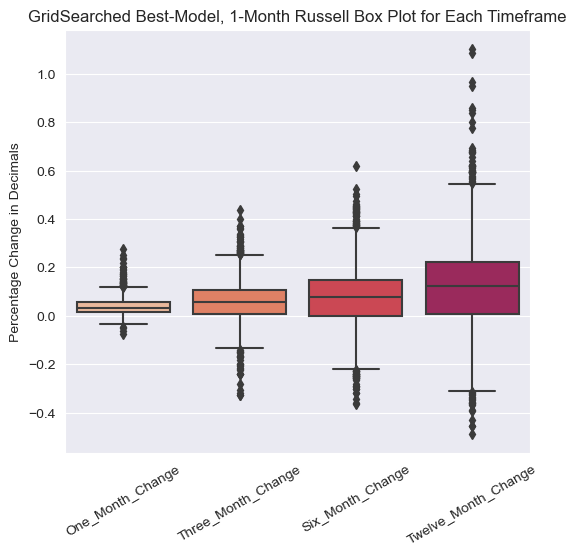

In [193]:
describe_predictions(Model.model_list[91], "^RUT", df, box=True)

# Best Three Month Models

In [186]:
show_time_horizon(Model.model_df, "Three")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
67,Nasdaq Random Forest 3-Month,0.958213,0.959704,0.975791,0.967676,0.156415,0.966491,0.969296,0.979475,0.974359,0.126787,0.993719
70,"GridSearched Best-Model, 3-Month Nasdaq",0.959247,0.959906,0.977244,0.968493,0.159316,0.965250,0.967468,0.979475,0.973435,0.128616,0.994037
68,Nasdaq Extra Trees 3-Month,0.960695,0.965733,0.973209,0.969453,0.147624,0.963388,0.974101,0.969451,0.971770,0.108444,0.993843
96,Russell Extra Trees 3-Month,0.945196,0.955493,0.957748,0.956594,0.159347,0.955251,0.963362,0.966138,0.964748,0.139951,0.988169
98,"GridSearched Best-Model, 3-Month Russell",0.946567,0.956673,0.958714,0.957676,0.151134,0.953881,0.962617,0.964697,0.963656,0.171133,0.986337


,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,2117.000000,2117.000000,2117.000000,2117.000000
mean,0.029724,0.089106,0.122473,0.195747
std,0.051841,0.076498,0.139644,0.216103
min,-0.222853,-0.054970,-0.288553,-0.449071
25%,0.000000,0.035358,0.044600,0.074872
50%,0.028477,0.070324,0.107989,0.192662
75%,0.057186,0.123355,0.191194,0.296338
max,0.272417,0.590369,0.801378,1.169694


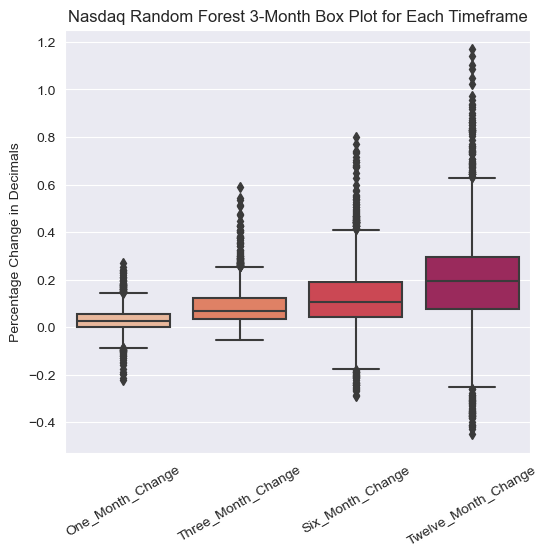

In [192]:
describe_predictions(Model.model_list[67], "^IXIC", df, box=True)

# Best Six Month Models

In [187]:
show_time_horizon(Model.model_df, "Six")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
75,Nasdaq Extra Trees 6-Month,0.973935,0.978040,0.983938,0.980964,0.091508,0.979522,0.983921,0.986565,0.985242,0.064942,0.997974
77,"GridSearched Best-Model, 6-Month Nasdaq",0.974348,0.978508,0.984089,0.981266,0.099475,0.979212,0.983482,0.986565,0.985021,0.063165,0.997822
74,Nasdaq Random Forest 6-Month,0.972383,0.975258,0.984544,0.979868,0.104606,0.975799,0.978251,0.987013,0.982613,0.083284,0.997723
105,"GridSearched Best-Model, 6-Month Russell",0.962095,0.973057,0.969677,0.971335,0.129780,0.970320,0.974930,0.979706,0.977312,0.123772,0.993767
47,S&P Extra Trees 6-Month,0.975034,0.980447,0.983044,0.981734,0.092498,0.969937,0.976229,0.979386,0.977805,0.091489,0.995081


,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,2239.000000,2239.000000,2239.000000,2239.000000
mean,0.022960,0.068979,0.141569,0.218725
std,0.054037,0.090843,0.114697,0.197577
min,-0.203158,-0.229182,-0.035943,-0.428201
25%,-0.007459,0.011130,0.061189,0.109543
50%,0.023454,0.060510,0.115187,0.202954
75%,0.053680,0.116243,0.190056,0.310737
max,0.272417,0.590369,0.801378,1.169694


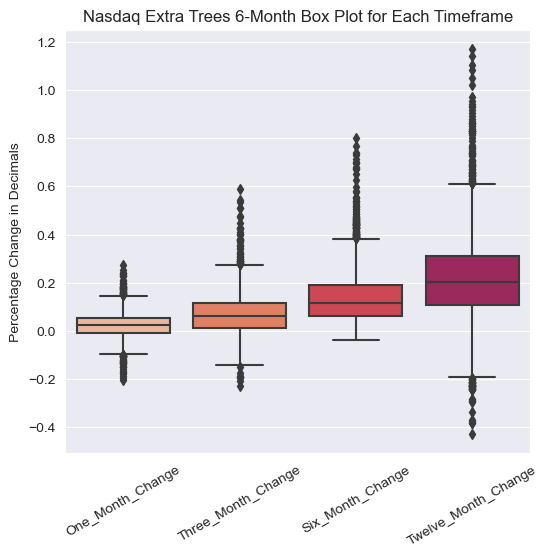

In [191]:
describe_predictions(Model.model_list[75], "^IXIC", df, box=True)

In [189]:
df["Ticker"].unique()

array(['^GSPC', '^IXIC', '^RUT', '^DJI'], dtype=object)

# Best Twelve Month Models

In [188]:
show_time_horizon(Model.model_df, "Twelve")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
84,"GridSearched Best-Model, 12-Month Nasdaq",0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
82,Nasdaq Extra Trees 12-Month,0.983037,0.986428,0.991047,0.988730,0.054830,0.986969,0.990095,0.992553,0.991322,0.061761,0.997269
81,Nasdaq Random Forest 12-Month,0.982933,0.984433,0.992975,0.988685,0.062937,0.986969,0.988081,0.994621,0.991340,0.051756,0.997922
83,Nasdaq XGBoost 12-Month,0.978486,0.980907,0.990634,0.985746,0.066204,0.985417,0.988861,0.991725,0.990291,0.047191,0.997531
54,S&P Extra Trees 12-Month,0.981412,0.985639,0.989267,0.987444,0.059547,0.983602,0.984770,0.992884,0.988810,0.047096,0.998773


,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,2433.000000,2433.000000,2433.000000,2433.000000
mean,0.018142,0.054772,0.114030,0.231378
std,0.055391,0.095843,0.134697,0.170105
min,-0.203158,-0.292537,-0.288817,-0.109905
25%,-0.013763,-0.003804,0.036799,0.114412
50%,0.020185,0.051704,0.099840,0.199532
75%,0.051284,0.106041,0.178407,0.303826
max,0.272417,0.590369,0.801378,1.169694


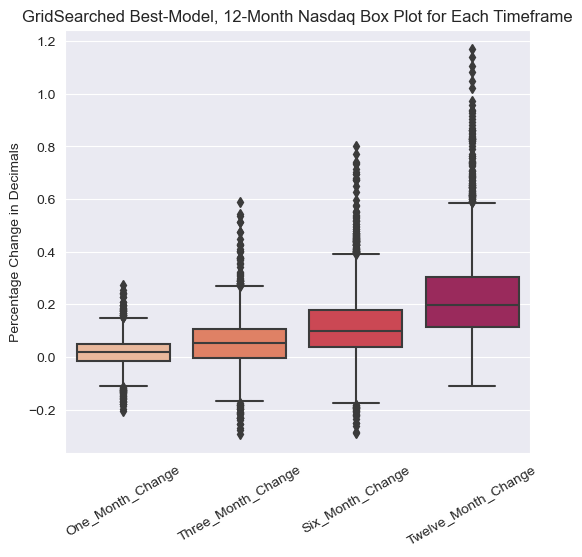

In [197]:
describe_predictions(Model.model_list[84], "^IXIC", df, box=True)

# Conclusions:

Without fail, ExtraTreesClassifer from sklearn.ensemble performed at the very top of every iteration of models, generally followed by RandomForest and XGBoost classifiers. The voting and stacking ensembles sometimes leapfrogged, but ExtraTrees was a reliable outperformer. I am a bit concerned that so many of these models were able to achieve AUC's near 1.0, meaning that they were close to perfect. One more key takeaway is that these models reinforce the ideas behind being a "Macro-economic" investor, given that the most important features were frequently GDP and Federal Interest Rates. Out of the technical indicators, ATR seemed to have the highest impact on classification. ATR is calculated by looking at daily prices; their high - low, high - previous close, and low - previous close, taking the largest of those 3 values, and adding it to a short-term moving average, making use of short-term data. I find it interesting that it was still a priority factor in longer time horizons as well. When investing at the index level, if minimizing risk is your objective, staying out of the market when interest rates are rising is a good basic tenet to adhere to. Also noteable is that the target time period of the model is extremely resistant to negative outliers, and therefore, these recommendations seem like very solid plays.

In [194]:
# import pickle 

# with open('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_classes_1.pkl', 'wb') as file:
#     pickle.dump(Model.model_list, file)

In [195]:
# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_CLASS_MODEL_DF.csv')

In [196]:
# Importance.df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_IMPORTANCES.csv')